In [1]:
import sys
in_colab = 'google.colab' in sys.modules
# import os
# os.getenv("COLAB_RELEASE_TAG")

In [2]:
%matplotlib inline

In [3]:
from __future__ import absolute_import, division, print_function
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML, Audio
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import scipy as sp
import pandas as pd
from ast import literal_eval
import seaborn as sns

import sys
import time

In [25]:
# from matplotlib.gridspec import GridSpec
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [4]:
if in_colab:
    !pip install pydub
from pydub import AudioSegment

In [5]:
import librosa
import soundfile as sf

In [6]:
import networkx as nx
# import nxviz
if in_colab:
    !pip install bctpy
import bct

In [7]:
import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

Non-nested functions

In [8]:
def nvg_dc(series, left=None, right=None, timeLine=None, all_visible = None):
    L = len(series)
    if left == None : left = 0
    if right == None : right = L
    if timeLine == None : timeLine = list(range(left, right))
    if all_visible == None : all_visible = []
    node_visible = []
    if left < right : # there must be at least two nodes in the time series
        k = list(series)[left:right].index(max(list(series[left:right]))) + left
#         k = np.array(series[left:right]).argmax() + left
        # check if k can see each node of series[left...right]
        for i in list(range(left,right)):
            if i != k :
                a = min(i,k)
                b = max(i,k)
                ya = float(series[a])
                ta = timeLine[a]
                yb = float(series[b])
                tb = timeLine[b]
                yc = series[a+1:b]
                tc = timeLine[a+1:b]
                if all(yc[j] < (ya + (yb - ya)*(tc[j] - ta)/(tb-ta)) for j in list(range(len(yc)))):
                    node_visible.append(timeLine[i])
        if len(node_visible)>0 : all_visible.append([timeLine[k], node_visible])
        nvg_dc(series, left, k, timeLine, all_visible = all_visible)
        nvg_dc(series, k+1, right, timeLine, all_visible = all_visible)
    return all_visible

def get_nvg_dc(ts):
    out = nvg_dc(ts)
    Adj = np.zeros((ts.size, ts.size))
    for el in out:
        Adj[el[0], el[1]] = 1
        Adj[el[-1::-1][0], el[-1::-1][1]] = 1
    return Adj

In [9]:
def get_envelope(sig, rate, order=6, fc=None):
    ## Using Hilbert transform ##
    envelope = np.abs(sp.signal.hilbert(sig))
    envelope = filter_lowpass(envelope, rate, order, fc)
    return envelope

In [10]:
def filter_lowpass(sig, rate, order=6, fc=None):
    ## Butterworth Low-pass Filter ##
    if fc is None:
        fc=rate/4
    sos = sp.signal.butter(N=order, Wn=fc/(rate/2), btype='low', output='sos')
    sig_filter = sp.signal.sosfiltfilt(sos, sig)
#     b, a = sp.signal.butter(N=order, Wn=fc/(rate/2), btype='low')
#     sig_filter = sp.signal.filtfilt(b, a, sig)
    return sig_filter

In [11]:
# def float2pcm(sig, dtype='int16'):
#     sig = np.asarray(sig)
#     if sig.dtype.kind != 'f':
#         raise TypeError("'sig' must be a float array")
#     dtype = np.dtype(dtype)
#     if dtype.kind not in 'iu':
#         raise TypeError("'dtype' must be an integer type")
#     i = np.iinfo(dtype)
#     abs_max = 2 ** (i.bits - 1)
#     offset = i.min + abs_max
#     return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)

# def pcm2float(sig, dtype='float32'):
#     sig = np.asarray(sig)
#     if sig.dtype.kind not in 'iu':
#         raise TypeError("'sig' must be an array of integers")
#     dtype = np.dtype(dtype)
#     if dtype.kind != 'f':
#         raise TypeError("'dtype' must be a floating point type")
#     i = np.iinfo(sig.dtype)
#     abs_max = 2 ** (i.bits - 1)
#     offset = i.min + abs_max
#     return (sig.astype(dtype) - offset) / abs_max


In [12]:
def stft_librosa(sig, rate, n_fft=1024, win_length=None, hop_length=None, normalize=True, **kwargs):
    if win_length is None:
        win_length = n_fft
    if hop_length is None:
        hop_length = int(0.25*n_fft)  
    # Librosa stft-spectrum
    spec = librosa.core.stft(sig, n_fft=n_fft, win_length=n_fft, hop_length=hop_length, window='hann', **kwargs)
    times = librosa.times_like(spec, sr=rate, hop_length=hop_length, n_fft=n_fft)
    freqs = librosa.fft_frequencies(sr=rate, n_fft=n_fft)
    # Convert power spec to dB scale (compute dB relative to peak power)
#     spec = librosa.amplitude_to_db(abs(librosa.core.magphase(spec))[0], ref=np.max, top_db=80)
#     spec = librosa.amplitude_to_db(abs(spec), ref=np.max, top_db=80)
    spec = abs(spec)
    # Normalize values between 0 and 1
    if normalize:
        spec -= spec.min()
        if not spec.max() == 0:
            spec /= spec.max()
        else:
            spec = np.clip(spec, 0, 1)
    spec.astype('float32')
    return times, freqs, spec

In [13]:
# def progressbar(it, prefix="", size=60, out=sys.stdout): # Python3.6+
#     count = len(it)
#     start = time.time() # time estimate start
#     def show(j):
#         x = int(size*j/count)
#         # time estimate calculation and string
#         remaining = ((time.time() - start) / j) * (count - j)        
#         mins, sec = divmod(remaining, 60) # limited to minutes
#         time_str = f"{int(mins):02}:{sec:03.1f}"
#         print(f"{prefix}[{u'█'*x}{('.'*(size-x))}] {j}/{count} Est wait {time_str}", end='\r', file=out, flush=True)
#     show(0.1) # avoid div/0 
#     for i, item in enumerate(it):
#         yield item
#         show(i+1)
#     print("\n", flush=True, file=out)

In [19]:
def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees
    rotation = np.rad2deg(angle+offset)
    if angle <= np.pi*4/5:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment

def add_labels(angles, values, labels, offset, ax):
    # This is the space between the end of the bar and the label
    padding = 4    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)
        # And finally add the text
        ax.text(
            x=angle, 
            y=value+padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor"
        )

# Mount

In [14]:
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive')

# Root dir

In [15]:
# if in_colab:
#     root_dir = '/content/drive/MyDrive/Post Doctorado/Analisis/Vowels/'
#     # root_dir = '/content/drive/MyDrive/Post Doctorado/Data/Vowels/'
# #     '/content/drive/MyDrive/Post Doctorado/Analisis/Visibility_graphs/Proyecto_visibility/'
# else:
#     root_dir = ''

In [16]:
# # # Descomentar si se quiere automatizar el seteado del directorio de trabajo según si es colab o no, y desde que cuenta asociada se abre colab. Pide otra vez permisos.
# # # Gabo tendría que adaptar la ubicación en su drive de la carpeta compartida
if in_colab:
    from google.colab import auth
    auth.authenticate_user()
    import requests
    gcloud_token = !gcloud auth print-access-token
    gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' +
                                    gcloud_token[0]).json()
    # !gcloud config get-value account
    if gcloud_tokeninfo['email'] == 'hbocaccio@gmail.com':
        root_dir = '/content/drive/MyDrive/Post Doctorado/Analisis/Vowels/'
    elif gcloud_tokeninfo['email'] == 'gabo.mindlin@gmail.com':
        root_dir = '/content/drive/MyDrive/Vowels/'
else:
    root_dir = ''

In [17]:
figures_dir = os.path.join(root_dir)
# figures_dir = os.path.join(root_dir, 'figures', 'draft')
# # variables_dir = os.path.join(root_dir, 'variables', 'vg_metrics')
# variables_dir = os.path.join(root_dir, 'run', 'variables')
# vg_dir = os.path.join(root_dir, 'run', 'variables', 'vg_metrics')
variables_dir = os.path.join(root_dir, 'variables')
vg_dir = os.path.join(root_dir, 'variables', 'vg_metrics')
results_order_dir = os.path.join(variables_dir, 'models')
results_threshold_dir = os.path.join(variables_dir, 'models_thresholds')

# Figures

In [18]:
# data_dir = os.path.join(root_dir, 'data', 'vowels_data_wav_segments_curated')
vocalization_speakers = np.loadtxt(os.path.join(vg_dir, 'vocalization_speakers.txt'), dtype='str')
vocalization_vowels = np.loadtxt(os.path.join(vg_dir, 'vocalization_vowels.txt'), dtype='str')
vocalization_files = np.loadtxt(os.path.join(vg_dir, 'vocalization_files.txt'), dtype='str')
# subject_names = os.listdir(data_dir)
subject_names = [s for s in np.unique(vocalization_speakers)]
vowels = ['a', 'e', 'i', 'o', 'u']

order = 13
dir_order = os.path.join(vg_dir, 'order_'+str(order))
H_functions = np.loadtxt(os.path.join(dir_order, 'H_functions.txt'))
freqs = np.loadtxt(os.path.join(dir_order, 'freqs.txt'))
df_metrics = pd.read_excel(os.path.join(dir_order, 'df_metrics.xlsx'), sheet_name='df_metrics')
giant_indices = np.loadtxt(os.path.join(dir_order, 'giant_indices.txt')).astype('int')
giant_speakers = vocalization_speakers[giant_indices]
giant_vowels = vocalization_vowels[giant_indices]
giant_files = vocalization_files[giant_indices]
H_functions_giant = H_functions[:, giant_indices]
droped = ['AvgDegree', 'Diameter']
df_metrics_subset = df_metrics.iloc[giant_indices].loc[df_metrics['Speaker'].isin(subject_names)].drop(droped, axis=1)

## Figure 1

In [19]:
# s = 2
# i = 2
# sr = 11025 # 22050
# n_fft = 512
# y, sr = librosa.load(os.path.join(data_dir, subject_names[s],
#                                   giant_files[giant_speakers == subject_names[s]][i]), sr=sr)
# times, frequencies, spec = stft_librosa(y, sr, n_fft=n_fft, win_length=None, hop_length=None, normalize=False)
# n = len(y)
# fft_result = np.fft.fft(y)
# fft_freqs = np.fft.fftfreq(n, d=1/sr)
# h = H_functions_giant[:, giant_speakers == subject_names[s]][:, i]
# f = freqs
# G = nx.from_numpy_array(get_nvg_dc(np.log10(h**2)))
# pos = [(i, np.log10(h[i]**2)) for i in np.arange(h.size)]

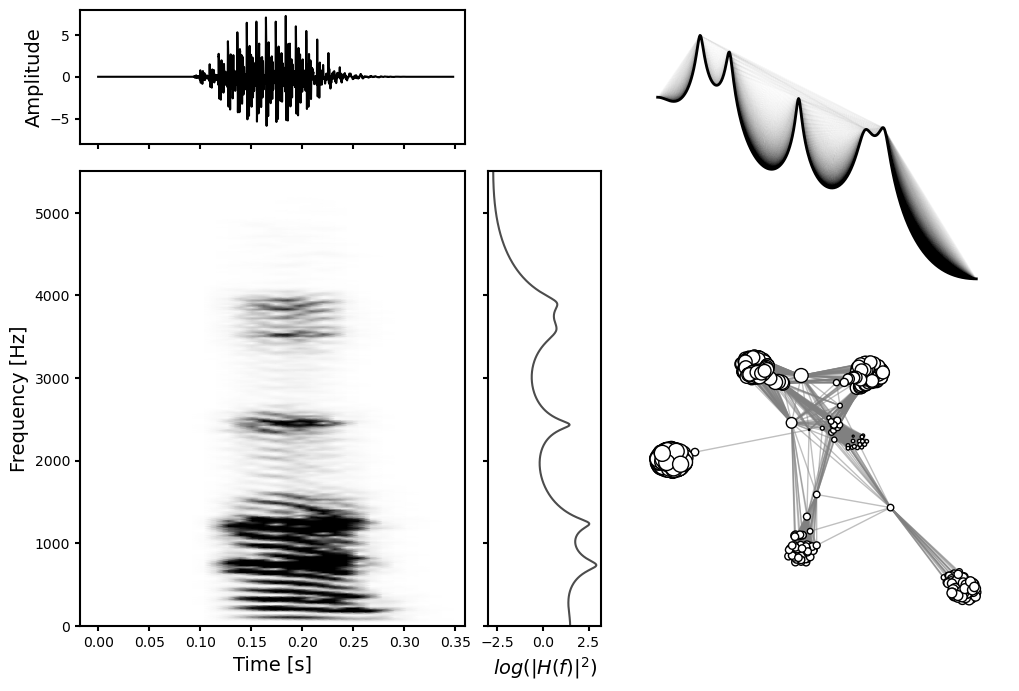

In [20]:
# from matplotlib.gridspec import GridSpec

# fig = plt.figure(figsize=(12, 8))
# gs = GridSpec(nrows=4, ncols=7)

# ax0 = fig.add_subplot(gs[0, 0:3])
# ax0.plot(np.arange(0, len(y)/sr, 1/sr), sp.stats.zscore(y), c='k', lw=1.5)
# ax0.set_ylim([-8, 8])
# plt.setp(ax0.get_xticklabels(), visible=False)
# ax0.set_ylabel('Amplitude', fontsize=14)
# for axis in ['top','bottom','left','right']:
#     ax0.spines[axis].set_linewidth(1.5)
# ax0.tick_params(width=1.5)

# ax1 = fig.add_subplot(gs[1:, 0:3], sharex=ax0)
# # ax1.imshow(spec, origin='lower', aspect='auto', cmap=plt.get_cmap('Greys'))
# # ax1.pcolormesh(times, frequencies, spec, cmap=plt.get_cmap('Greys'), vmin=0, vmax=1, shading='gouraud', rasterized=False)
# ax1.pcolormesh(times, frequencies, spec, cmap=plt.get_cmap('Greys'), vmin=-0, vmax=1, shading='gouraud', rasterized=True)
# ax1.set_ylabel('Frequency [Hz]', fontsize=14)
# ax1.set_xlabel('Time [s]', fontsize=14)
# for axis in ['top','bottom','left','right']:
#     ax1.spines[axis].set_linewidth(1.5)
# ax1.tick_params(width=1.5)

# # factor = 0.1
# ax2 = fig.add_subplot(gs[1:, 3], sharey=ax1)
# # ax2.plot(np.abs(fft_result[:n//2])*factor, fft_freqs[:n//2], c='gray', alpha=0.8, label='FFT')
# ax2.plot(np.log10(h**2), f, c='k', alpha=0.7) #label='$log(|H(f)|^2) [a.u.]$'
# ax2.set_xlabel('$log(|H(f)|^2)$', fontsize=14)
# # ax2.plot(np.abs(h), f, c='k', alpha=1, label='|H(f)| [a.u.]')
# # ax2.legend()
# # handle, label = ax2.get_legend_handles_labels()
# plt.setp(ax2.get_yticklabels(), visible=False);
# for axis in ['top','bottom','left','right']:
#     ax2.spines[axis].set_linewidth(1.5)
# ax2.tick_params(width=1.5)

# # ax3 = fig.add_subplot(gs[0, 3], sharey=ax0, sharex=ax2)
# # # ax3.stairs(counts*100, bins, fill=True, color='gray')
# # plt.setp(ax3.get_yticklabels(), visible=False)
# # plt.setp(ax3.get_xticklabels(), visible=False)

# ax4 = fig.add_subplot(gs[0:2, 4:])
# ax4.plot(np.log10(h**2), c='k', lw=2)
# nx.draw_networkx(G, pos=pos, with_labels=False, node_size=0,
#                  node_color=[(0, 0, 0, 0)], edge_color=[(0, 0, 0, 0.005)], ax=ax4)
# ax4.set_axis_off()

# ax5 = fig.add_subplot(gs[2:, 4:])
# seed = 2 #29 #0
# nx.draw(G, node_size=(np.array(nx.degree(G))[:,1]-np.array(nx.degree(G))[:,1].min()+1),
#         node_color='lightgray', edge_color='gray', pos=nx.spring_layout(G, seed=seed), ax=ax5)
# for a in ax5.get_children():
#     if 'PathCollection' in str(a):
#         a.set_facecolor('w')
#         a.set_edgecolor('k')
#     if 'LineCollection' in str(a):
#         a.set_alpha(0.5)
# ax5.set_axis_off()

# # fig.tight_layout()
# # # fig.subplots_adjust(bottom=0.25, wspace=0.25)
# # fig.savefig(os.path.join(figures_dir, 'fig_methods.png'), format='png', dpi=300, facecolor='w')
# # fig.savefig(os.path.join(figures_dir, 'fig_methods.pdf'), format='pdf', dpi=300, facecolor='w')

## Figure 2

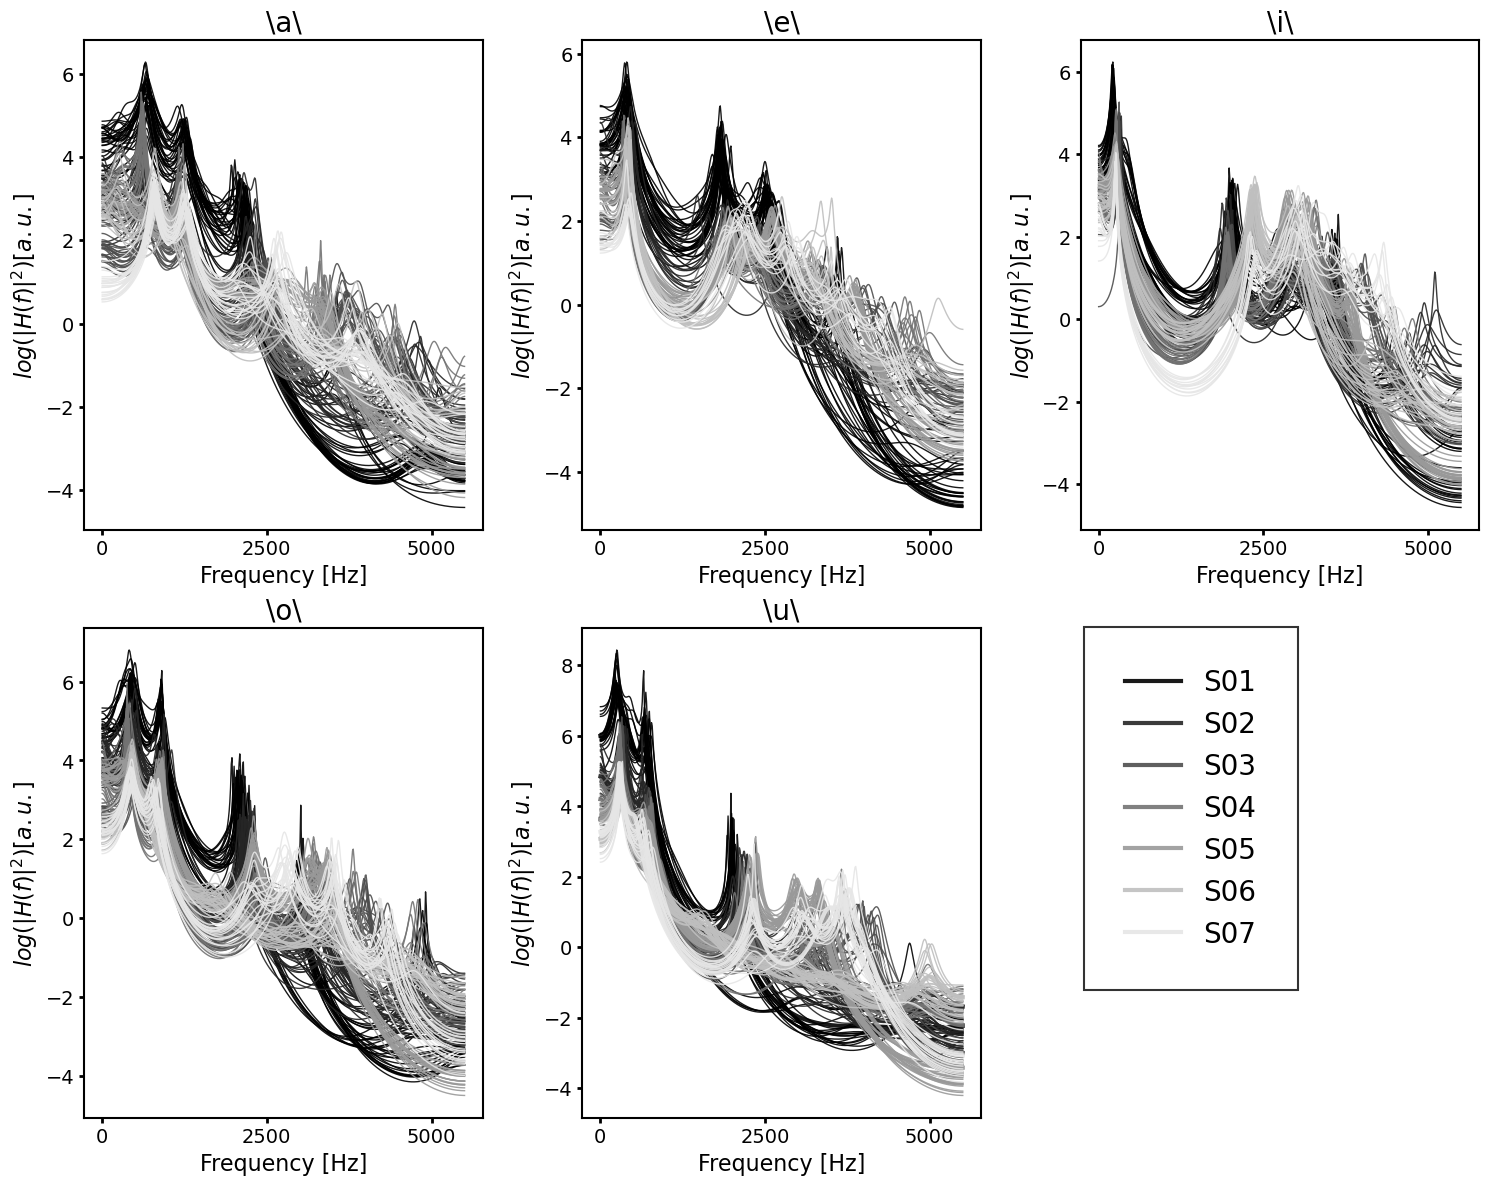

In [21]:
colors = [[0.9-0.9*((len(subject_names)-1)-ss)/(len(subject_names)-1)]*3 for ss in np.arange(len(subject_names))]

# id_axs = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]
id_axs = [(0,0), (0,1), (0,2), (1,0), (1,1)]
fig, axs = plt.subplots(2, 3, figsize=(18,14))
for v in np.arange(len(vowels)):
    for ss in np.arange(len(subject_names)):
        h_matrix = H_functions_giant[:, (giant_speakers == subject_names[ss]) &
                                     (giant_vowels == vowels[v])]
        f_matrix = freqs[:]
        for i in np.arange(h_matrix.shape[1]):
            h = h_matrix[:, i]
            f = f_matrix
            axs[id_axs[v]].plot(f, np.log10(np.abs(h)**2),
                                c=colors[ss], alpha=0.9, lw=1, label=subject_names[ss])
    axs[id_axs[v]].set_title('\\'+vowels[v]+'\\', fontsize=20)
    axs[id_axs[v]].set_xlabel('Frequency [Hz]', fontsize=16)
    axs[id_axs[v]].set_ylabel('$log(|H(f)|^2) [a.u.]$', fontsize=16)
    axs[id_axs[v]].set_xticks([0, 2500, 5000])
    if v == 4:
#         axs[id_axs[v+1]].axis('off')
        axs[1,2].axis('off')
        handles, labels = axs[id_axs[v]].get_legend_handles_labels()
        _, idx = np.unique(np.array(labels), return_index=True)
#         axs[id_axs[v]].legend(np.array(handles)[idx], np.array(labels)[np.sort(idx)], loc='upper left')
        new_handles = list(np.array(handles)[idx])
        for n in np.arange(len(new_handles)):
            new_handles[n].set_linewidth(3)
        new_labels = ['S'+str(i).zfill(2) for i in np.arange(idx.size)+1]
        leg = axs[id_axs[v]].legend(new_handles, new_labels, loc='upper right', frameon=True,
                                    bbox_to_anchor=(1.83, 1.03), fancybox=False, fontsize=20, borderpad=1.5)
        leg.get_frame().set_facecolor('w')
        leg.get_frame().set_edgecolor('k')
        leg.get_frame().set_linewidth(1.5)
    for axis in ['top','bottom','left','right']:
        axs[id_axs[v]].spines[axis].set_linewidth(1.5)
    axs[id_axs[v]].tick_params(width=2)
    axs[id_axs[v]].tick_params(labelsize=14)
fig.subplots_adjust(hspace=0.2, wspace=0.25)
# fig.savefig(os.path.join(figures_dir, 'fig_spectra.png'), format='png', dpi=300, facecolor='w')
# fig.savefig(os.path.join(figures_dir, 'fig_spectra.pdf'), format='pdf', dpi=300, facecolor='w')

## Figure 3

In [22]:
[o for o in df_metrics_subset.keys()[4:]]

['Density', 'ASPL', 'CC', 'Q']

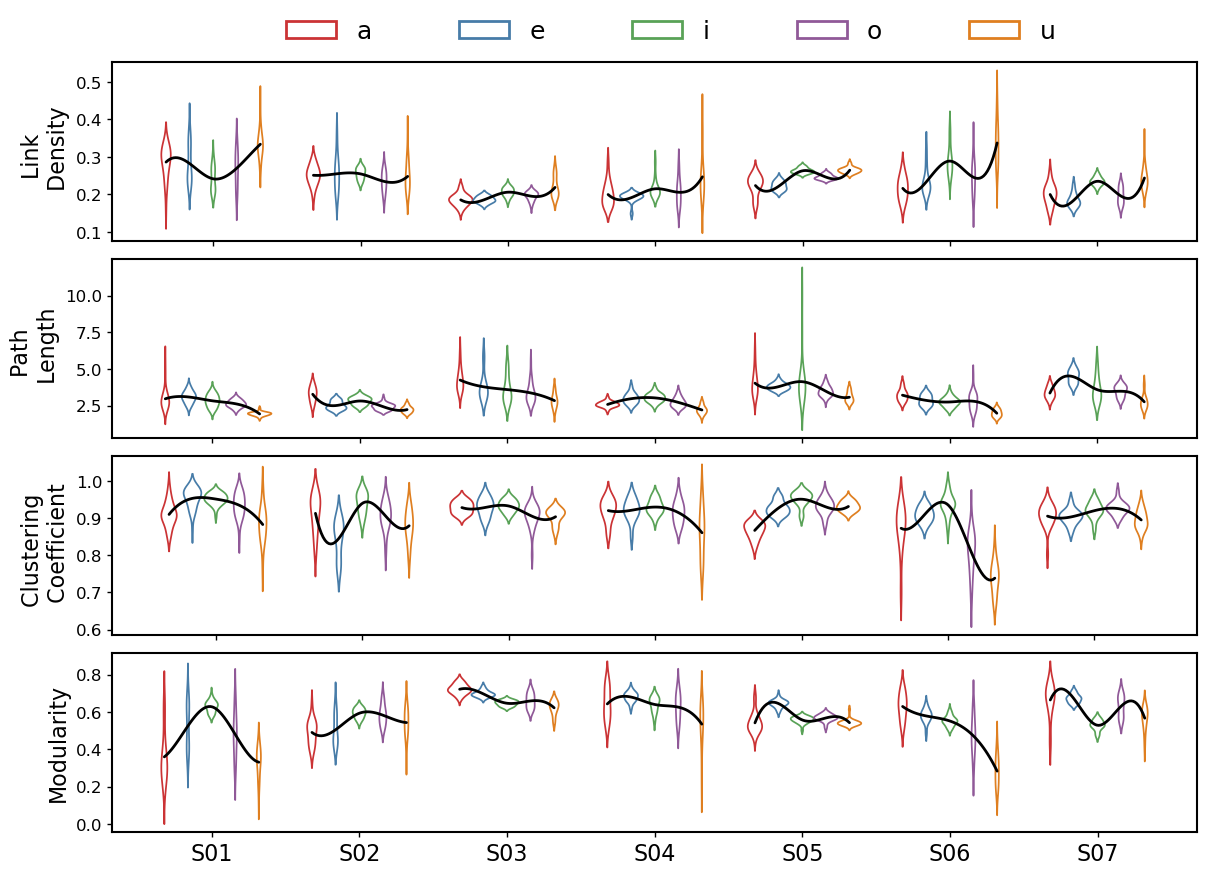

In [27]:
# options = ['AvgDegree', 'Diameter', 'Density', 'ASPL', 'CC', 'Q']
# options = ['Diameter', 'Density', 'ASPL', 'CC', 'Q']
options = ['Density', 'ASPL', 'CC', 'Q']
# options = [o for o in df_metrics_subset.keys()[4:]]
# ylabels = options
# ylabels = ['Average \n Degree', 'Diameter', 'Density', 'Path \n Length', 'Clustering \n Coefficient', 'Modularity']
ylabels = ['Link \n Density', 'Path \n Length', 'Clustering \n Coefficient', 'Modularity']

fig, axs = plt.subplots(len(options), 1, figsize=(14,10))
for o in np.arange(len(options)):
# #    sns.violinplot(data=df_metrics_subset, x='Speaker', y=options[o], hue='Vowel',
# #                   palette='Set1', saturation=0.75, inner=None, bw=0.6, ax=axs[o]); #, inner='point',
    sns.violinplot(data=df_metrics_subset, x='Speaker', y=options[o], hue='Vowel',
                   palette='Set1', saturation=0.75, inner=None, bw=0.6, ax=axs[o]); #, inner='point',
# #                    inner_kws=dict(box_width=15, whis_width=2, color=".8"), ax=ax); #, palette=colors

# #     sns.lineplot(data=df_metrics_subset, x='Speaker', y=options[o], hue='Vowel',
# #                  palette='Set1', legend=False, ax=axs[o])
#     colors_violin = []
    ymean_tmp = df_metrics_subset.groupby(['Speaker', 'Vowel'])[options[o]].mean().ravel()
    xmean_tmp = []
    for collection in axs[o].collections:
        if isinstance(collection, matplotlib.collections.PolyCollection):
#             colors_violin.append(collection.get_facecolor())
            collection.set_edgecolor(collection.get_facecolor())
            collection.set_facecolor('none')
            xmean_tmp.append(np.mean(collection.get_paths()[0].vertices[:,0]))
#     if len(axs[o].lines) == 2 * len(colors_violin):  # suppose inner=='box'
#         for lin1, lin2, color in zip(axs[o].lines[::2], axs[o].lines[1::2], colors_violin):
#             lin1.set_color(color)
#             lin2.set_color(color)
    for handle in axs[o].legend_.legend_handles:
        if isinstance(handle, matplotlib.patches.Rectangle):
            handle.set_edgecolor(handle.get_facecolor())
            handle.set_facecolor('none')
            handle.set_linewidth(1.5)

    axs[o].set_ylabel(ylabels[o], fontsize=16)
    axs[o].set_xlabel('')
    axs[o].set_xticks([i for i in np.arange(np.unique(df_metrics_subset['Speaker']).size)])
    if o < len(options)-1:
        axs[o].set_xticklabels([])
    else:
#         axs[o].set_xticklabels(['S'+str(i).zfill(2) for i in np.arange(len(selected_subjects))+1])
        axs[o].set_xticklabels(['S'+str(i).zfill(2) for i in np.arange(np.unique(df_metrics_subset['Speaker']).size)+1])
    for axis in ['top','bottom','left','right']:
        axs[o].spines[axis].set_linewidth(1.5)
    if o == 0:
        handles, labels = axs[o].get_legend_handles_labels()
        
        for n in np.arange(len(handles)):
            handles[n].set_edgecolor(handles[n].get_facecolor())
            handles[n].set_linewidth(2)
            handles[n].set_facecolor('w')
#         axs[o].legend(handles[:], labels[:], bbox_to_anchor=(0.175, 1-0.02, 1, 0), loc="lower left",# mode="expand",
#                       ncol=len(labels), columnspacing=3.65, frameon=False, fontsize=16) #, borderaxespad=0.4
        axs[o].legend(handles[:], labels[:], bbox_to_anchor=(0.14, 1-0.02, 1, 0), loc="lower left",# mode="expand",
                      ncol=len(labels), columnspacing=3.5, frameon=False, fontsize=18) #, borderaxespad=0.4
    else:
        axs[o].legend().set_visible(False)
    axs[o].tick_params(width=1)
    axs[o].tick_params(labelsize=12)
    axs[o].tick_params(axis='x', labelsize=16)
    xmean = np.array(xmean_tmp).reshape((len(subject_names), len(vowels)))
    ymean = ymean_tmp.reshape((len(subject_names), len(vowels)))

    for m in np.arange(ymean.shape[0]):
        x = np.linspace(xmean[m].min(), xmean[m].max(), num=50, endpoint=True, retstep=False, dtype=None, axis=0)
        y = sp.interpolate.make_interp_spline(xmean[m], ymean[m])(x)
#         y = sp.interpolate.interp1d(xmean[m], ymean[m], kind='cubic')(x)
#         axs[o].plot(xmean[m], ymean[m], c='k', lw=2, solid_capstyle='round')
        axs[o].plot(x, y, c='k', lw=2, solid_capstyle='round')
fig.subplots_adjust(hspace=0.1)
# fig.savefig(os.path.join(figures_dir, 'fig_vg_metrics.png'), format='png', dpi=300, facecolor='w')
# fig.savefig(os.path.join(figures_dir, 'fig_vg_metrics.pdf'), format='pdf', dpi=300, facecolor='w')

## Figure 4

Load grid search

In [20]:
M = 10
scores_matrix_min = []
scores_matrix_max = []
# for dirs in os.listdir(os.path.join(root_dir,'variables','models')):
#     model_dir = os.path.join(root_dir,'variables','models', dirs)
#     features_dir = os.path.join(model_dir, 'order_'+str(order))
#     df_results_rf = pd.read_csv(os.path.join(features_dir, 'df_results_rf.csv'), converters={'params': literal_eval})
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    df_results_rf = pd.read_csv(os.path.join(model_dir, 'df_results_rf.csv'), converters={'params': literal_eval})
    selected_params = ['param_n_estimators', 'param_max_depth']
    scores_matrix = df_results_rf.pivot(index=selected_params[0], columns=selected_params[1], values='mean_test_score')
    scores_matrix_min.append(scores_matrix.values.min())
    scores_matrix_max.append(scores_matrix.values.max())

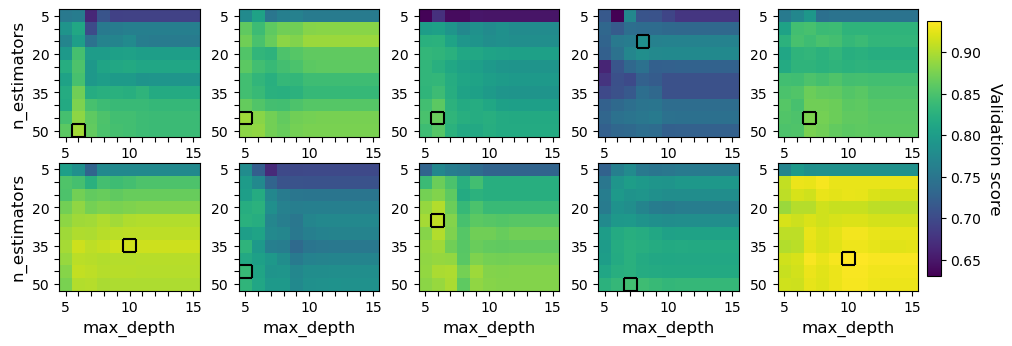

In [27]:
seed = 2
np.random.seed(seed)
# cmap_vowels = matplotlib.colormaps['Set1'].colors[:len(vowels)]
# colors_vowels = [list(c) for c in np.vstack(np.array([[c]*len(features) for c in cmap_vowels]))]
# subindices = [[0:2, 0:8]]
fig = plt.figure(figsize=(12, 18))
# gs = GridSpec(nrows=10, ncols=8)
outer = gridspec.GridSpec(nrows=8, ncols=10, wspace=3.5, hspace=0.9)
# outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)


n_rows1 = 2
inner1 = gridspec.GridSpecFromSubplotSpec(n_rows1, int(M/n_rows1), subplot_spec=outer[0:2, 0:10],
                                          wspace=-0.15, hspace=0.2)
axs1 = []
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    df_results_rf = pd.read_csv(os.path.join(model_dir, 'df_results_rf.csv'), converters={'params': literal_eval})
    param_grid = {'n_estimators':  np.arange(5, 50+1, 5), 'max_depth': np.arange(5, 15+1)}
    selected_params = ['param_n_estimators', 'param_max_depth']
    best_params = df_results_rf['params'][np.argmax(df_results_rf['mean_test_score'])]
    labels_params = [p.split('param_')[1] for p in selected_params] #list(param_grid.keys())
    scores_matrix = df_results_rf.pivot(index=selected_params[0], columns=selected_params[1], values='mean_test_score')
    axs1.append(fig.add_subplot(inner1[m]))
    im = axs1[m].imshow(scores_matrix, vmin=min(scores_matrix_min), vmax=max(scores_matrix_max))
#     ax = fig.add_subplot(inner1[m])
#     im = ax.imshow(scores_matrix)
#     axs1.append(ax)
    axs1[m].set_yticks(np.arange(np.unique(df_results_rf[selected_params[0]]).size))
    yticklabels = ["{:.0f}".format(x) if (x-5)%15==0 else '' for x in np.unique(df_results_rf[selected_params[0]])]
    axs1[m].set_yticklabels(yticklabels)
    if np.divmod(m, int(M/n_rows1))[1] == 0:
        axs1[m].set_ylabel(labels_params[0], fontsize=12)
    else:
        axs1[m].set_ylabel('')
    axs1[m].set_xticks(np.arange(np.unique(df_results_rf[selected_params[1]]).size))
    xticklabels = ["{:.0f}".format(x) if (x-5)%5==0 else '' for x in np.unique(df_results_rf[selected_params[1]])]
    axs1[m].set_xticklabels(xticklabels)
    if np.divmod(m, int(M/n_rows1))[0] == 1:
        axs1[m].set_xlabel(labels_params[1], fontsize=12)
    else:
        axs1[m].set_xlabel('')
    y1=np.where(param_grid[labels_params[0]] == best_params[labels_params[0]])[0][0]
    x1=np.where(param_grid[labels_params[1]] == best_params[labels_params[1]])[0][0]
    axs1[m].hlines(y=[y1-0.5, y1+0.5], xmin=x1-0.5, xmax=x1+0.5, colors='k', lw=1.5)
    axs1[m].vlines(x=[x1-0.5, x1+0.5], ymin=y1-0.5, ymax=y1+0.5, colors='k', lw=1.5)
    box = axs1[m].get_position()
    box.x0 = box.x0 - 0.035
    box.x1 = box.x1 - 0.035
    axs1[m].set_position(box)
# cbar = fig.colorbar(im, ax=[axs1[int(M/n_rows1)-1], axs1[M-1]], anchor=(0.5, 0.25), pad=0.1) #, shrink=0.8
# cbar.set_label('Validation accuracy', rotation=270)
axins = inset_axes(axs1[M-1],
                   width="10%",  # width = 5% of parent_bbox width
                   height="200%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.1, 1, 1),
                   bbox_transform=axs1[M-1].transAxes,
                   borderpad=0.1,
                   )
cbar = fig.colorbar(im, cax=axins)
cbar.set_label('Validation score', rotation=270, fontsize=12, labelpad=15)

Load performances

In [20]:
precisions = np.array(())
recalls = np.array(())
f1scores = np.array(())
supports = np.array(())
precisions_avg = np.array(())
recalls_avg = np.array(())
f1scores_avg = np.array(())
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    seed = 42
    np.random.seed(seed)
    df_results_rf = pd.read_csv(os.path.join(model_dir, 'df_results_rf.csv'), converters={'params': literal_eval})
    selected_params = ['param_n_estimators', 'param_max_depth']
    best_params = df_results_rf['params'][np.argmax(df_results_rf['mean_test_score'])]
    y_test = np.loadtxt(os.path.join(model_dir, 'y_test_rf.txt'), dtype='int')
    y_pred_test = np.loadtxt(os.path.join(model_dir, 'y_pred_test_rf.txt'), dtype='int')
#     print(sk.metrics.classification_report(y_test_reselect, y_pred_test_reselect))    
    (precision, recall, f1score, support) = sk.metrics.precision_recall_fscore_support(y_true=y_test,
                                                                                       y_pred=y_pred_test,
                                                                                       average=None)
    (precision_avg, recall_avg, f1score_avg, _) = sk.metrics.precision_recall_fscore_support(y_true=y_test,
                                                                                             y_pred=y_pred_test,
                                                                                             average='macro')
    precisions = np.append(precisions, precision)
    recalls = np.append(recalls, recall)
    f1scores = np.append(f1scores, f1score)
    supports = np.append(supports, support)
    precisions_avg = np.append(precisions_avg, precision_avg)
    recalls_avg = np.append(recalls_avg, recall_avg)
    f1scores_avg = np.append(f1scores_avg, f1score_avg)

In [21]:
precisions_random = np.array(())
recalls_random = np.array(())
f1scores_random = np.array(())
supports_random = np.array(())
precisions_avg_random = np.array(())
recalls_avg_random = np.array(())
f1scores_avg_random = np.array(())
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    seed = 42
    np.random.seed(seed)
    df_results_rf = pd.read_csv(os.path.join(model_dir, 'df_results_rf.csv'), converters={'params': literal_eval})
    selected_params = ['param_n_estimators', 'param_max_depth']
    best_params = df_results_rf['params'][np.argmax(df_results_rf['mean_test_score'])]
    y_test = np.loadtxt(os.path.join(model_dir, 'y_test_rf.txt'), dtype='int')
    y_test_random = np.random.RandomState(seed=0).permutation(y_test)
    y_pred_test = np.loadtxt(os.path.join(model_dir, 'y_pred_test_rf.txt'), dtype='int')
    (precision, recall, f1score, support) = metrics.precision_recall_fscore_support(y_true=y_test_random,
                                                                                    y_pred=y_pred_test,
                                                                                    average=None)
    (precision_avg, recall_avg, f1score_avg, _) = metrics.precision_recall_fscore_support(y_true=y_test_random,
                                                                                          y_pred=y_pred_test,
                                                                                          average='macro')
    precisions_random = np.append(precisions_random, precision)
    recalls_random = np.append(recalls_random, recall)
    f1scores_random = np.append(f1scores_random, f1score)
    supports_random = np.append(supports_random, support)
    precisions_avg_random = np.append(precisions_avg_random, precision_avg)
    recalls_avg_random = np.append(recalls_avg_random, recall_avg)
    f1scores_avg_random = np.append(f1scores_avg_random, f1score_avg)

In [22]:
df_performances = pd.DataFrame({'Model': list(np.repeat(np.arange(M)+1, len(subject_names)))*3*2,
                                'Subjects': list(np.arange(len(subject_names))+1)*M*3*2,
                                'Metric': ['Precision']*precisions.shape[0]+
                                ['Recall']*recalls.shape[0]+
                                ['F1-score']*f1scores.shape[0]+
                                ['Precision']*precisions.shape[0]+
                                ['Recall']*recalls.shape[0]+
                                ['F1-score']*f1scores.shape[0],
                                'Random': [0]*precisions.shape[0]*3+[1]*precisions.shape[0]*3,
                                'Values': np.hstack((precisions, recalls, f1scores,
                                                    precisions_random, recalls_random, f1scores_random))})

In [23]:
df_performances_avg = pd.DataFrame({'Model': list(np.arange(M)+1)*3*2,
                                    'Metric': ['Precision']*precisions_avg.shape[0]+
                                    ['Recall']*recalls_avg.shape[0]+
                                    ['F1-score']*f1scores_avg.shape[0]+
                                    ['Precision']*precisions_avg.shape[0]+
                                    ['Recall']*recalls_avg.shape[0]+
                                    ['F1-score']*f1scores_avg.shape[0],
                                    'Random': [0]*precisions_avg.shape[0]*3+[1]*precisions_avg.shape[0]*3,
                                    'Values': np.hstack((precisions_avg, recalls_avg, f1scores_avg,
                                                         precisions_avg_random, recalls_avg_random, f1scores_avg_random))})

Load feature importance

In [39]:
importances_means = []
importances_stds = []
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    seed = 42
    np.random.seed(seed)
    importances_mean = np.loadtxt(os.path.join(model_dir, 'importances_mean_rf.txt'))
    importances_std = np.loadtxt(os.path.join(model_dir, 'importances_std_rf.txt'))
#     estimators = np.loadtxt(os.path.join(model_dir, 'estimators_rf.txt'))
    importances_means.append(importances_mean)
    importances_stds.append(importances_std)
importances_means = np.array(importances_means)
importances_stds = np.array(importances_stds)

In [40]:
shap_importances_train = []
shap_importances_test = []
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    seed = 42
    np.random.seed(seed)
    shap_train = np.loadtxt(os.path.join(model_dir, 'shap_importance_train.txt'))
    shap_test = np.loadtxt(os.path.join(model_dir, 'shap_importance_test.txt'))
    shap_importances_train.append(shap_train)
    shap_importances_test.append(shap_test)
shap_importances_train = np.array(shap_importances_train)
shap_importances_test = np.array(shap_importances_test)

In [41]:
shap_importances_train_kernel = []
shap_importances_test_kernel = []
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    seed = 42
    np.random.seed(seed)
    shap_train_kernel = np.loadtxt(os.path.join(model_dir, 'shap_importance_train_kernel.txt'))
    shap_test_kernel = np.loadtxt(os.path.join(model_dir, 'shap_importance_test_kernel.txt'))
    shap_importances_train_kernel.append(shap_train_kernel)
    shap_importances_test_kernel.append(shap_test_kernel)
shap_importances_train_kernel = np.array(shap_importances_train_kernel)
shap_importances_test_kernel = np.array(shap_importances_test_kernel)

In [42]:
permutations_importances_train = []
permutations_importances_test = []
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    seed = 42
    np.random.seed(seed)
    permutation_train = np.loadtxt(os.path.join(model_dir, 'permutation_importances_train.txt'))
    permutation_test = np.loadtxt(os.path.join(model_dir, 'permutation_importances_test.txt'))
    permutations_importances_train.append(permutation_train)
    permutations_importances_test.append(permutation_test)
permutations_importances_train = np.array(permutations_importances_train)
permutations_importances_test = np.array(permutations_importances_test)

In [43]:
features = list(df_metrics_subset.keys()[4:].ravel())
feature_name = []
for i in np.arange(importances_means.shape[1]):
    feature_name.append(sum([int(importances_means.shape[1]/len(vowels))*[vowel] for vowel in vowels], [])[i]+
                        '_'+(len(vowels)*list(features))[i])

In [44]:
df_importance = pd.DataFrame({'Model': list(np.repeat(np.arange(M)+1, len(features)*len(vowels))),
                              'Feature': features*len(vowels)*M,
                              'Vowel': np.hstack(np.array([[v]*len(features) for v in vowels]*M)),
                              'FeatureName': feature_name*M,
                              'ImportanceMean': importances_means.ravel(),
                              'ImportanceStd': importances_stds.ravel(),
                              'Shap_train': shap_importances_train.ravel(),
                              'Shap_test': shap_importances_test.ravel(),
                              'Shap_train_kernel': shap_importances_train_kernel.ravel(),
                              'Shap_test_kernel': shap_importances_test_kernel.ravel(),
                              'Permutation_train': permutations_importances_train.ravel(),
                              'Permutation_test': permutations_importances_test.ravel()
                             })

In [47]:
df_importance.to_csv('out.csv', index=False)

In [62]:
df_importance.groupby('Feature')['ImportanceMean']

In [63]:
df_importance

,Model,Feature,Vowel,FeatureName,ImportanceMean,ImportanceStd,Shap_train,Shap_test,Shap_train_kernel,Shap_test_kernel,Permutation_train,Permutation_test
0,1,Density,a,a_Density,0.015701,0.026087,0.004333,0.004325,0.031845,0.039904,0.000021,0.002086
1,1,ASPL,a,a_ASPL,0.088161,0.062789,0.022186,0.021451,0.062220,0.088296,0.059607,0.072114
2,1,CC,a,a_CC,0.016657,0.027063,0.005793,0.006061,0.024568,0.024655,0.000000,0.003914
3,1,Q,a,a_Q,0.035675,0.039507,0.010241,0.011139,0.060382,0.094010,0.000200,0.017829
4,1,Density,e,e_Density,0.086940,0.074565,0.034443,0.035095,0.182600,0.201110,0.003629,0.038386
...,...,...,...,...,...,...,...,...,...,...,...,...
195,10,Q,o,o_Q,0.011704,0.021036,0.003718,0.004024,0.017161,0.014172,0.000000,0.001771
196,10,Density,u,u_Density,0.014154,0.020981,0.005318,0.005749,0.030956,0.029694,0.000000,0.002586
197,10,ASPL,u,u_ASPL,0.041454,0.055042,0.017004,0.017520,0.124966,0.128424,0.000000,0.010171
198,10,CC,u,u_CC,0.082530,0.069367,0.031410,0.031347,0.265762,0.507958,0.059064,0.081886


In [50]:
groups = [df_importance.loc[df_importance["Vowel"] == v, "ImportanceMean"] for v in df_importance["Vowel"].unique()]
sp.stats.kruskal(*groups)
# stat, p_value = kruskal(*groups)
# print(f"Kruskal-Wallis test: H={stat:.4f}, p={p_value:.4e}")

KruskalResult(statistic=45.89665671641785, pvalue=2.5878722241942462e-09)

In [51]:
groups

[0      0.015701
 1      0.088161
 2      0.016657
 3      0.035675
 20     0.015898
 21     0.071529
 22     0.020598
 23     0.058976
 40     0.018652
 41     0.077933
 42     0.009511
 43     0.059132
 60     0.016009
 61     0.046665
 62     0.009799
 63     0.064763
 80     0.020397
 81     0.069862
 82     0.007429
 83     0.044578
 100    0.014847
 101    0.064956
 102    0.013006
 103    0.048734
 120    0.014316
 121    0.067837
 122    0.018165
 123    0.062683
 140    0.022300
 141    0.049057
 142    0.006724
 143    0.063524
 160    0.024033
 161    0.062349
 162    0.017140
 163    0.081230
 180    0.017762
 181    0.071616
 182    0.012763
 183    0.097354
 Name: ImportanceMean, dtype: float64,
 4      0.086940
 5      0.087102
 6      0.047031
 7      0.075032
 24     0.072597
 25     0.067281
 26     0.031152
 27     0.090484
 44     0.081728
 45     0.112796
 46     0.056964
 47     0.039722
 64     0.078059
 65     0.100099
 66     0.056812
 67     0.063235
 84     0

In [55]:
import scikit_posthocs

# Test de Dunn con corrección de Bonferroni
posthoc = scikit_posthocs.posthoc_dunn(df, val_col="ImportanceMean", group_col="Vowel", p_adjust="bonferroni")

print(posthoc)  # Matriz de comparación de p-valores


ModuleNotFoundError: No module named 'scikit_posthocs'

In [54]:
# from itertools import combinations
# vowel_groups = df.groupby("Vowel")["ImportanceMean"]
# comparisons = list(combinations(vowel_groups.groups.keys(), 2))
# p_values = []
# for v1, v2 in comparisons:
#     stat, p = mannwhitneyu(vowel_groups.get_group(v1), vowel_groups.get_group(v2), alternative="two-sided")
#     p_values.append(p)
#     print(f"Comparación {v1} vs {v2}: U={stat:.4f}, p={p:.4e}")
# p_adjusted = np.array(p_values) * len(p_values)
# p_adjusted = np.minimum(p_adjusted, 1.0)  # Asegurar que no supere 1
# for (v1, v2), p_corr in zip(comparisons, p_adjusted):
#     print(f"Comparación {v1} vs {v2} (Bonferroni corregido): p={p_corr:.4e}")

Plot v1

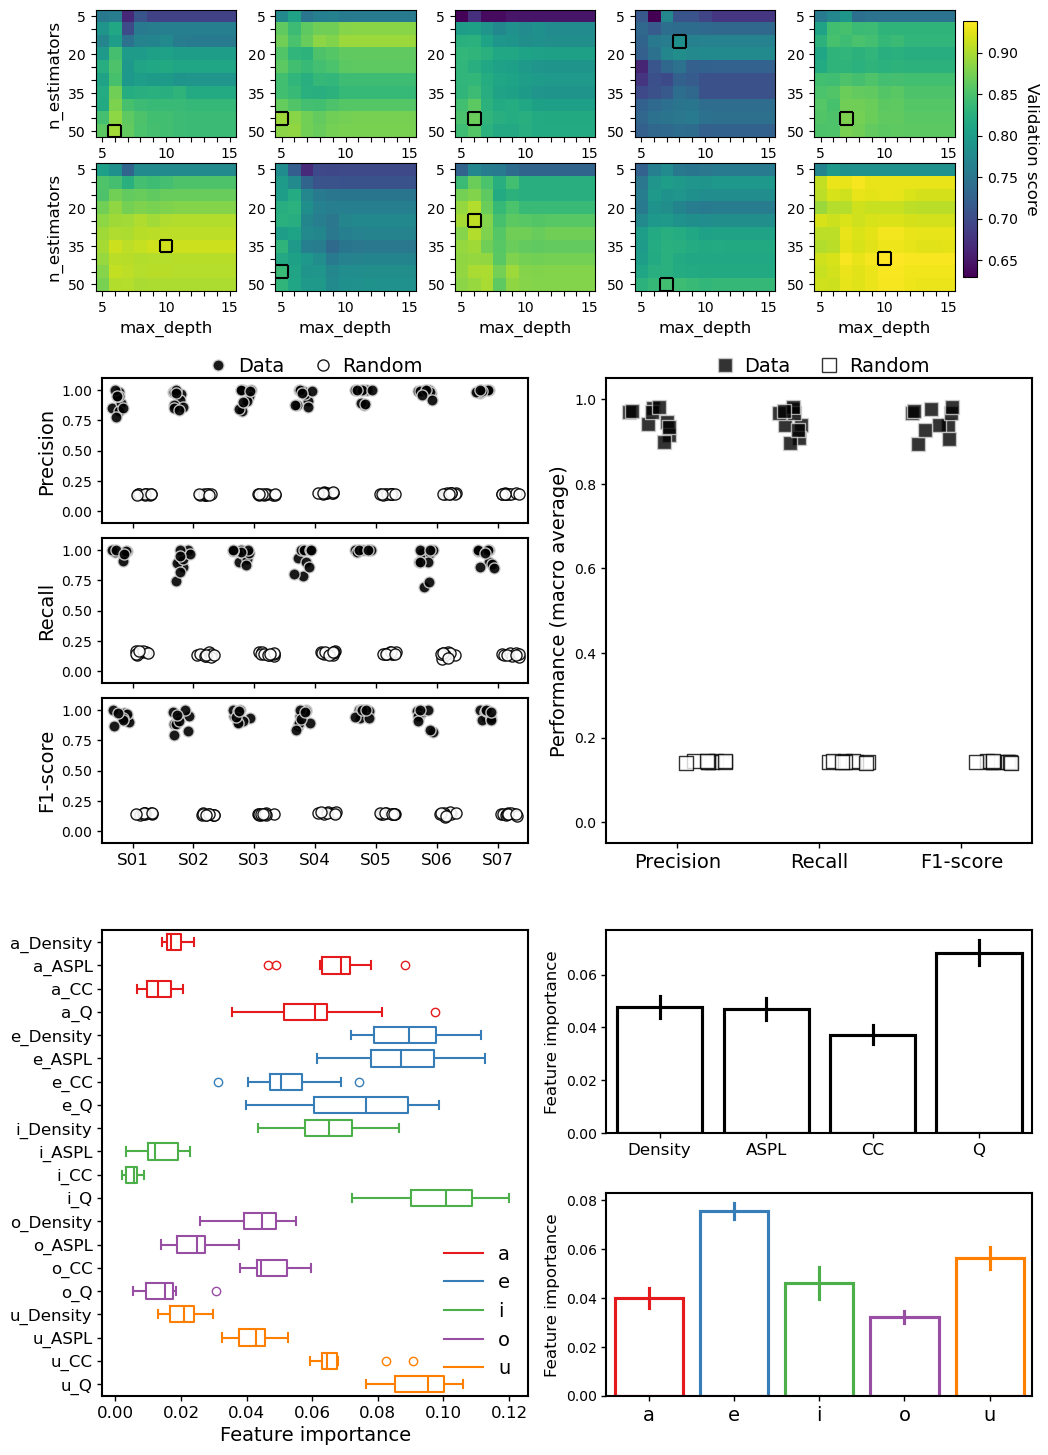

In [36]:
# from matplotlib.gridspec import GridSpec
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

seed = 2
np.random.seed(seed)
cmap_vowels = matplotlib.colormaps['Set1'].colors[:len(vowels)]
colors_vowels = [list(c) for c in np.vstack(np.array([[c]*len(features) for c in cmap_vowels]))]
# subindices = [[0:2, 0:8]]
fig = plt.figure(figsize=(12, 18))
# gs = GridSpec(nrows=10, ncols=8)
outer = gridspec.GridSpec(nrows=8, ncols=10, wspace=3.5, hspace=0.9)
# outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)


n_rows1 = 2
inner1 = gridspec.GridSpecFromSubplotSpec(n_rows1, int(M/n_rows1), subplot_spec=outer[0:2, 0:10],
                                          wspace=-0.15, hspace=0.2)
axs1 = []
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    df_results_rf = pd.read_csv(os.path.join(model_dir, 'df_results_rf.csv'), converters={'params': literal_eval})
    param_grid = {'n_estimators':  np.arange(5, 50+1, 5), 'max_depth': np.arange(5, 15+1)}
    selected_params = ['param_n_estimators', 'param_max_depth']
    best_params = df_results_rf['params'][np.argmax(df_results_rf['mean_test_score'])]
    labels_params = [p.split('param_')[1] for p in selected_params] #list(param_grid.keys())
    scores_matrix = df_results_rf.pivot(index=selected_params[0], columns=selected_params[1], values='mean_test_score')
    axs1.append(fig.add_subplot(inner1[m]))
    im = axs1[m].imshow(scores_matrix, vmin=min(scores_matrix_min), vmax=max(scores_matrix_max))
#     ax = fig.add_subplot(inner1[m])
#     im = ax.imshow(scores_matrix)
#     axs1.append(ax)
    axs1[m].set_yticks(np.arange(np.unique(df_results_rf[selected_params[0]]).size))
    yticklabels = ["{:.0f}".format(x) if (x-5)%15==0 else '' for x in np.unique(df_results_rf[selected_params[0]])]
    axs1[m].set_yticklabels(yticklabels)
    if np.divmod(m, int(M/n_rows1))[1] == 0:
        axs1[m].set_ylabel(labels_params[0], fontsize=12)
    else:
        axs1[m].set_ylabel('')
    axs1[m].set_xticks(np.arange(np.unique(df_results_rf[selected_params[1]]).size))
    xticklabels = ["{:.0f}".format(x) if (x-5)%5==0 else '' for x in np.unique(df_results_rf[selected_params[1]])]
    axs1[m].set_xticklabels(xticklabels)
    if np.divmod(m, int(M/n_rows1))[0] == 1:
        axs1[m].set_xlabel(labels_params[1], fontsize=12)
    else:
        axs1[m].set_xlabel('')
    y1=np.where(param_grid[labels_params[0]] == best_params[labels_params[0]])[0][0]
    x1=np.where(param_grid[labels_params[1]] == best_params[labels_params[1]])[0][0]
    axs1[m].hlines(y=[y1-0.5, y1+0.5], xmin=x1-0.5, xmax=x1+0.5, colors='k', lw=1.5)
    axs1[m].vlines(x=[x1-0.5, x1+0.5], ymin=y1-0.5, ymax=y1+0.5, colors='k', lw=1.5)
    box = axs1[m].get_position()
    box.x0 = box.x0 - 0.035
    box.x1 = box.x1 - 0.035
    axs1[m].set_position(box)
# cbar = fig.colorbar(im, ax=[axs1[int(M/n_rows1)-1], axs1[M-1]], anchor=(0.5, 0.25), pad=0.1) #, shrink=0.8
# cbar.set_label('Validation accuracy', rotation=270)
axins = inset_axes(axs1[M-1],
                   width="10%",  # width = 5% of parent_bbox width
                   height="200%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.1, 1, 1),
                   bbox_transform=axs1[M-1].transAxes,
                   borderpad=0.1,
                   )
cbar = fig.colorbar(im, cax=axins)
cbar.set_label('Validation score', rotation=270, fontsize=12, labelpad=15)


performance_name = ['Precision', 'Recall', 'F1-score']
xtickslabels = ['S'+str(i).zfill(2) for i in np.arange(len(subject_names))+1]
fcolor = ['k', 'w']
ecolor = ['lightgray', 'k']
labels_dict = {'0': 'Data', '1': 'Random'}
n_rows4 = len(performance_name)
# inner4 = gridspec.GridSpecFromSubplotSpec(n_rows4, 1, subplot_spec=outer[5:8, 0:5], wspace=-0.2, hspace=0.1)
inner4 = gridspec.GridSpecFromSubplotSpec(n_rows4, 1, subplot_spec=outer[2:5, 0:5], hspace=0.1)
axs4 = []
for p in np.arange(len(performance_name)):
    df_tmp = df_performances[df_performances['Metric'] == performance_name[p]]
    axs4.append(fig.add_subplot(inner4[p]))
    sns.stripplot(data=df_tmp, x='Subjects', y='Values', hue='Random', size=8, marker="o",
                  dodge=True, jitter=0.3, alpha=.9, linewidth=0, legend=True, ax=axs4[p])
    e = 0
    l = 0
    for children in axs4[p].get_children():
        if 'Path' in str(children):
            children.set_linewidth(1)
            children.set_facecolor(fcolor[np.mod(e,2)])
            children.set_edgecolor(ecolor[np.mod(e,2)])
            e += 1
        if 'Line2D' in str(children):
            children.set_markerfacecolor(fcolor[np.mod(l,2)])
            children.set_markeredgecolor(ecolor[np.mod(l,2)])
            children.set_markeredgewidth(1)
            l += 1
    axs4[p].set_ylabel(performance_name[p], fontsize=14)
    axs4[p].set_xlabel('')
    axs4[p].set_ylim([0-0.1, 1+0.1])
    axs4[p].set_xticks(np.arange(len(subject_names)))
    if p < len(performance_name)-1:
        axs4[p].set_xticklabels([])
    else:
        axs4[p].set_xticklabels(xtickslabels)
    for axis in ['top','bottom','left','right']:
        axs4[p].spines[axis].set_linewidth(1.5)
    if p == 0:
        handles, labels_tmp = axs4[p].get_legend_handles_labels()
        labels = [labels_dict[label] for label in labels_tmp]
        positions = axs4[p].get_position()
        bbox = (positions.x0+0.125, positions.y0+0.15, positions.x1, positions.y1)
        axs4[p].legend(handles[:], labels[:], bbox_to_anchor=bbox, loc="center",
                       ncol=len(labels), columnspacing=1, handletextpad=0.01, frameon=False, fontsize=14)
    else:
        axs4[p].legend().set_visible(False)
    axs4[p].tick_params(width=1)
    axs4[p].tick_params(labelsize=10)
    axs4[p].tick_params(axis='x', labelsize=12)
    

performance_name = ['Precision', 'Recall', 'F1-score']
fcolor = ['k', 'w']
ecolor = ['lightgray', 'k']
labels_dict = {'0': 'Data', '1': 'Random'}
# inner3 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[5:8, 5:10], wspace=0.1, hspace=0.1)
# axs3 = fig.add_subplot(inner3)
# axs5 = fig.add_subplot(outer[5:8, 5:10])
axs5 = fig.add_subplot(outer[2:5, 5:10])
sns.stripplot(data=df_performances_avg, x='Metric', y='Values', hue='Random', size=10, marker="s",
              dodge=True, jitter=0.3, alpha=.8, linewidth=0, legend=True, ax=axs5)
e = 0
l = 0
for children in axs5.get_children():
    if 'Path' in str(children):
        children.set_linewidth(1)
        children.set_facecolor(fcolor[np.mod(e,2)])
        children.set_edgecolor(ecolor[np.mod(e,2)])
        e += 1
    if 'Line2D' in str(children):
        children.set_markerfacecolor(fcolor[np.mod(l,2)])
        children.set_markeredgecolor(ecolor[np.mod(l,2)])
        children.set_markeredgewidth(1)
        l += 1
axs5.set_xticks(np.arange(len(performance_name)))
axs5.set_xticklabels(performance_name)
axs5.set_xlabel('')
axs5.set_ylim([0-0.05, 1+0.05])
axs5.set_ylabel('Performance (macro average)', fontsize=14)
for axis in ['top','bottom','left','right']:
    axs5.spines[axis].set_linewidth(1.5)
handles, labels_tmp = axs5.get_legend_handles_labels()
labels = [labels_dict[label] for label in labels_tmp]
positions = axs5.get_position()
bbox = (positions.x0-0.5, positions.y0+0.27, positions.x1, positions.y1)
axs5.legend(handles[:], labels[:], bbox_to_anchor=bbox, loc="center",
            ncol=len(labels), columnspacing=1, handletextpad=0.01, frameon=False, fontsize=14)
axs5.tick_params(width=1)
axs5.tick_params(labelsize=10)
axs5.tick_params(axis='x', labelsize=14)


# axs2 = fig.add_subplot(outer[2:5, 0:5])
axs2 = fig.add_subplot(outer[5:8, 0:5])
sns.boxplot(data=df_importance, x='ImportanceMean', y='FeatureName', palette=colors_vowels,
            fill=False, legend=True, width=0.7, ax=axs2) # , label=feature_labels
axs2.set_ylabel('')
axs2.set_xlabel('Feature importance', fontsize=14)
for axis in ['top','bottom','left','right']:
    axs2.spines[axis].set_linewidth(1.5)
handle_lines = []
for v in np.arange(len(vowels)):
    handle_lines.append(matplotlib.lines.Line2D([0], [0], label=vowels[v], color=cmap_vowels[v]))
axs2.legend(handle_lines, vowels, frameon=False, fontsize=14, loc='lower right')
axs2.tick_params(width=1)
axs2.tick_params(labelsize=12)
axs2.tick_params(axis='x', labelsize=12)


n_rows3 = 2
group = ['Feature', 'Vowel']
isfill = [False, False]
xlabelsize = [12, 14]
# xticklabels3 = ['Diameter', 'Density', 'Path \n Length', 'Clustering \n Coefficient', 'Modularity']
# inner3 = gridspec.GridSpecFromSubplotSpec(n_rows3, 1, subplot_spec=outer[2:5, 5:10], hspace=0.3)
inner3 = gridspec.GridSpecFromSubplotSpec(n_rows3, 1, subplot_spec=outer[5:8, 5:10], hspace=0.3)
axs3 = []
for i in range(n_rows3):
    axs3.append(fig.add_subplot(inner3[i]))
    if i==0:
        sns.barplot(data=df_importance, x=group[i], y='ImportanceMean',
                    errorbar='se', fill=isfill[i], color='k', ax=axs3[i])
#         axs3[i].set_xticks(np.arange(len(xticklabels3)))
#         axs3[i].set_xticklabels(xticklabels3, fontsize=10)
    elif i==1:
        sns.barplot(data=df_importance, x=group[i], y='ImportanceMean',
                    errorbar='se', fill=isfill[i], palette=cmap_vowels, ax=axs3[i])
    axs3[i].set_ylabel('Feature importance', fontsize=12)
    axs3[i].set_xlabel('')
    for axis in ['top','bottom','left','right']:
        axs3[i].spines[axis].set_linewidth(1.5)
    axs3[i].tick_params(width=1)
    axs3[i].tick_params(labelsize=10)
    axs3[i].tick_params(axis='x', labelsize=xlabelsize[i])

# fig.savefig(os.path.join(figures_dir, 'fig_models_rf.png'), format='png', dpi=300, facecolor='w')
# fig.savefig(os.path.join(figures_dir, 'fig_models_rf.pdf'), format='pdf', dpi=300, facecolor='w')

Plot v2 (circular)

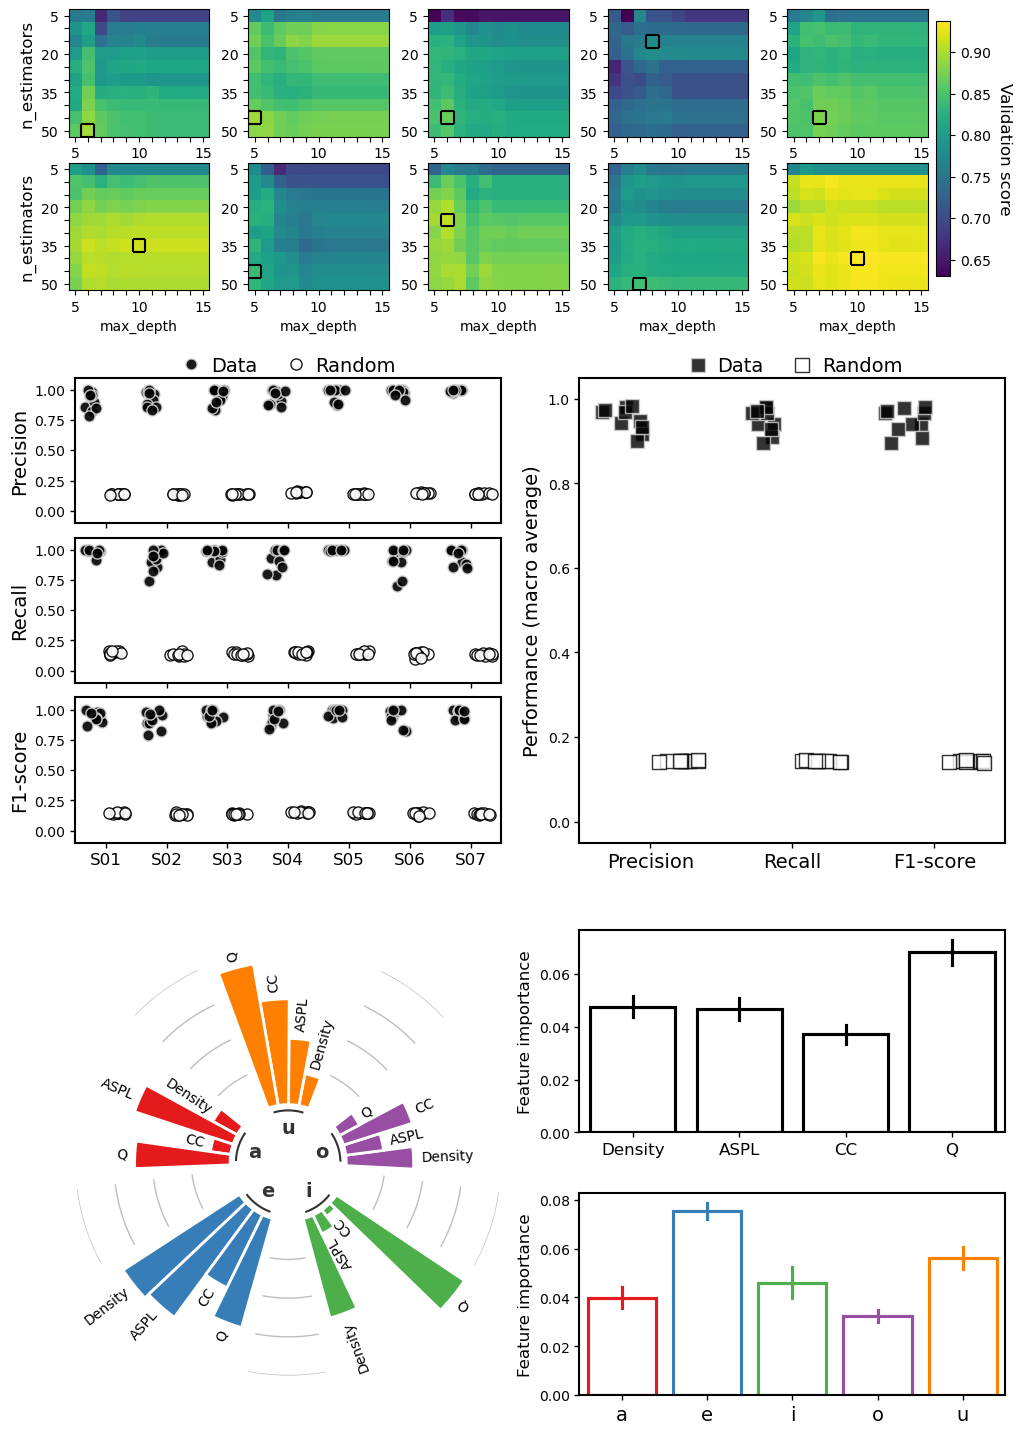

In [38]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

seed = 2
np.random.seed(seed)
cmap_vowels = matplotlib.colormaps['Set1'].colors[:len(vowels)]
colors_vowels = [list(c) for c in np.vstack(np.array([[c]*len(features) for c in cmap_vowels]))]

fig = plt.figure(figsize=(12, 18))
outer = gridspec.GridSpec(nrows=8, ncols=10, wspace=3.5, hspace=0.9)


n_rows1 = 2
inner1 = gridspec.GridSpecFromSubplotSpec(n_rows1, int(M/n_rows1), subplot_spec=outer[0:2, 0:10],
                                          wspace=-0.15, hspace=0.2)
axs1 = []
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    df_results_rf = pd.read_csv(os.path.join(model_dir, 'df_results_rf.csv'), converters={'params': literal_eval})
    param_grid = {'n_estimators':  np.arange(5, 50+1, 5), 'max_depth': np.arange(5, 15+1)}
    selected_params = ['param_n_estimators', 'param_max_depth']
    best_params = df_results_rf['params'][np.argmax(df_results_rf['mean_test_score'])]
    labels_params = [p.split('param_')[1] for p in selected_params] #list(param_grid.keys())
    scores_matrix = df_results_rf.pivot(index=selected_params[0], columns=selected_params[1], values='mean_test_score')
    axs1.append(fig.add_subplot(inner1[m]))
    im = axs1[m].imshow(scores_matrix, vmin=min(scores_matrix_min), vmax=max(scores_matrix_max))
    axs1[m].set_yticks(np.arange(np.unique(df_results_rf[selected_params[0]]).size))
    yticklabels = ["{:.0f}".format(x) if (x-5)%15==0 else '' for x in np.unique(df_results_rf[selected_params[0]])]
    axs1[m].set_yticklabels(yticklabels)
    if np.divmod(m, int(M/n_rows1))[1] == 0:
        axs1[m].set_ylabel(labels_params[0], fontsize=12)
    else:
        axs1[m].set_ylabel('')
    axs1[m].set_xticks(np.arange(np.unique(df_results_rf[selected_params[1]]).size))
    xticklabels = ["{:.0f}".format(x) if (x-5)%5==0 else '' for x in np.unique(df_results_rf[selected_params[1]])]
    axs1[m].set_xticklabels(xticklabels)
    if np.divmod(m, int(M/n_rows1))[0] == 1:
        axs1[m].set_xlabel(labels_params[1], fontsize=12)
    else:
        axs1[m].set_xlabel('')
    axs1[m].set_xlabel(labels_params[1], fontsize=10)
    y1=np.where(param_grid[labels_params[0]] == best_params[labels_params[0]])[0][0]
    x1=np.where(param_grid[labels_params[1]] == best_params[labels_params[1]])[0][0]
    axs1[m].hlines(y=[y1-0.5, y1+0.5], xmin=x1-0.5, xmax=x1+0.5, colors='k', lw=1.5)
    axs1[m].vlines(x=[x1-0.5, x1+0.5], ymin=y1-0.5, ymax=y1+0.5, colors='k', lw=1.5)
    box = axs1[m].get_position()
    box.x0 = box.x0 - 0.035
    box.x1 = box.x1 - 0.035
    axs1[m].set_position(box)
axins = inset_axes(axs1[M-1],
                   width="10%",  # width = 5% of parent_bbox width
                   height="200%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.1, 1, 1),
                   bbox_transform=axs1[M-1].transAxes,
                   borderpad=0.1,
                   )
cbar = fig.colorbar(im, cax=axins)
cbar.set_label('Validation score', rotation=270, fontsize=12, labelpad=15)


performance_name = ['Precision', 'Recall', 'F1-score']
xtickslabels = ['S'+str(i).zfill(2) for i in np.arange(len(subject_names))+1]
fcolor = ['k', 'w']
ecolor = ['lightgray', 'k']
labels_dict = {'0': 'Data', '1': 'Random'}
n_rows4 = len(performance_name)
inner4 = gridspec.GridSpecFromSubplotSpec(n_rows4, 1, subplot_spec=outer[2:5, 0:5], hspace=0.1)
axs4 = []
for p in np.arange(len(performance_name)):
    df_tmp = df_performances[df_performances['Metric'] == performance_name[p]]
    axs4.append(fig.add_subplot(inner4[p]))
    sns.stripplot(data=df_tmp, x='Subjects', y='Values', hue='Random', size=8, marker="o",
                  dodge=True, jitter=0.3, alpha=.9, linewidth=0, legend=True, ax=axs4[p])
    e = 0
    l = 0
    for children in axs4[p].get_children():
        if 'Path' in str(children):
            children.set_linewidth(1)
            children.set_facecolor(fcolor[np.mod(e,2)])
            children.set_edgecolor(ecolor[np.mod(e,2)])
            e += 1
        if 'Line2D' in str(children):
            children.set_markerfacecolor(fcolor[np.mod(l,2)])
            children.set_markeredgecolor(ecolor[np.mod(l,2)])
            children.set_markeredgewidth(1)
            l += 1
    axs4[p].set_ylabel(performance_name[p], fontsize=14)
    axs4[p].set_xlabel('')
    axs4[p].set_ylim([0-0.1, 1+0.1])
    axs4[p].set_xticks(np.arange(len(subject_names)))
    if p < len(performance_name)-1:
        axs4[p].set_xticklabels([])
    else:
        axs4[p].set_xticklabels(xtickslabels)
    for axis in ['top','bottom','left','right']:
        axs4[p].spines[axis].set_linewidth(1.5)
    if p == 0:
        handles, labels_tmp = axs4[p].get_legend_handles_labels()
        labels = [labels_dict[label] for label in labels_tmp]
        positions = axs4[p].get_position()
        bbox = (positions.x0+0.125, positions.y0+0.15, positions.x1, positions.y1)
        axs4[p].legend(handles[:], labels[:], bbox_to_anchor=bbox, loc="center",
                       ncol=len(labels), columnspacing=1, handletextpad=0.01, frameon=False, fontsize=14)
    else:
        axs4[p].legend().set_visible(False)
    axs4[p].tick_params(width=1)
    axs4[p].tick_params(labelsize=10)
    axs4[p].tick_params(axis='x', labelsize=12)
    

performance_name = ['Precision', 'Recall', 'F1-score']
fcolor = ['k', 'w']
ecolor = ['lightgray', 'k']
labels_dict = {'0': 'Data', '1': 'Random'}
axs5 = fig.add_subplot(outer[2:5, 5:10])
sns.stripplot(data=df_performances_avg, x='Metric', y='Values', hue='Random', size=10, marker="s",
              dodge=True, jitter=0.3, alpha=.8, linewidth=0, legend=True, ax=axs5)
e = 0
l = 0
for children in axs5.get_children():
    if 'Path' in str(children):
        children.set_linewidth(1)
        children.set_facecolor(fcolor[np.mod(e,2)])
        children.set_edgecolor(ecolor[np.mod(e,2)])
        e += 1
    if 'Line2D' in str(children):
        children.set_markerfacecolor(fcolor[np.mod(l,2)])
        children.set_markeredgecolor(ecolor[np.mod(l,2)])
        children.set_markeredgewidth(1)
        l += 1
axs5.set_xticks(np.arange(len(performance_name)))
axs5.set_xticklabels(performance_name)
axs5.set_xlabel('')
axs5.set_ylim([0-0.05, 1+0.05])
axs5.set_ylabel('Performance (macro average)', fontsize=14)
for axis in ['top','bottom','left','right']:
    axs5.spines[axis].set_linewidth(1.5)
handles, labels_tmp = axs5.get_legend_handles_labels()
labels = [labels_dict[label] for label in labels_tmp]
positions = axs5.get_position()
bbox = (positions.x0-0.5, positions.y0+0.27, positions.x1, positions.y1)
axs5.legend(handles[:], labels[:], bbox_to_anchor=bbox, loc="center",
            ncol=len(labels), columnspacing=1, handletextpad=0.01, frameon=False, fontsize=14)
axs5.tick_params(width=1)
axs5.tick_params(labelsize=10)
axs5.tick_params(axis='x', labelsize=14)


axs2 = fig.add_subplot(outer[5:8, 0:5], polar=True)
df_tmp = df_importance.groupby(['Feature', 'Vowel'], sort=False, as_index=False)['ImportanceMean'].mean()
values = df_tmp['ImportanceMean'].values*800
feature_labels = df_tmp['Feature'].values
vowel_group = df_tmp['Vowel'].values
pad = 3
# angles = np.linspace(0, 2*np.pi, num=len(values)+pad*len(np.unique(vowel_group)), endpoint=False)
angles = np.linspace(-np.pi/2, np.pi*3/2, num=len(values)+pad*len(np.unique(vowel_group)), endpoint=False)
width = (2*np.pi)/len(angles)
groups_size = [len(i[1]) for i in df_tmp.groupby('Vowel')]
offset = 0
idxs = []
for size in groups_size:
    idxs += list(range(offset+pad, offset+size+pad))
    offset += size+pad
axs2.set_theta_offset(offset)
axs2.set_ylim(-30, 80)
axs2.set_frame_on(False)
axs2.xaxis.grid(False)
axs2.yaxis.grid(False)
axs2.set_xticks([])
axs2.set_yticks([])
axs2.bar(angles[idxs], values, width=width, color=colors_vowels, edgecolor="white", linewidth=2)
add_labels(angles[idxs], values, feature_labels, offset, axs2)
offset = 0
for group, size in zip(vowels, groups_size):
    x1 = np.linspace(angles[offset+pad], angles[offset+size+pad-1], num=50)
    axs2.plot(x1, [-3] * 50, color="#333333")    
    axs2.text(np.mean(x1), -12, group, color="#333333", fontsize=14, fontweight="bold", ha="center", va="center")
    x2 = np.linspace(angles[offset], angles[offset+pad-1], num=50)
    axs2.plot(x2, [20] * 50, color="#bebebe", lw=1)
    axs2.plot(x2, [40] * 50, color="#bebebe", lw=1)
    axs2.plot(x2, [60] * 50, color="#bebebe", lw=1)
    axs2.plot(x2, [80] * 50, color="#bebebe", lw=1)
    offset += size+pad


n_rows3 = 2
group = ['Feature', 'Vowel']
isfill = [False, False]
xlabelsize = [12, 14]
# xticklabels3 = ['Diameter', 'Density', 'Path \n Length', 'Clustering \n Coefficient', 'Modularity']
inner3 = gridspec.GridSpecFromSubplotSpec(n_rows3, 1, subplot_spec=outer[5:8, 5:10], hspace=0.3)
axs3 = []
for i in range(n_rows3):
    axs3.append(fig.add_subplot(inner3[i]))
    if i==0:
        sns.barplot(data=df_importance, x=group[i], y='ImportanceMean',
                    errorbar='se', fill=isfill[i], color='k', ax=axs3[i])
#         axs3[i].set_xticks(np.arange(len(xticklabels3)))
#         axs3[i].set_xticklabels(xticklabels3, fontsize=10)
    elif i==1:
        sns.barplot(data=df_importance, x=group[i], y='ImportanceMean',
                    errorbar='se', fill=isfill[i], palette=cmap_vowels, ax=axs3[i])
    axs3[i].set_ylabel('Feature importance', fontsize=12)
    axs3[i].set_xlabel('')
    for axis in ['top','bottom','left','right']:
        axs3[i].spines[axis].set_linewidth(1.5)
    axs3[i].tick_params(width=1)
    axs3[i].tick_params(labelsize=10)
    axs3[i].tick_params(axis='x', labelsize=xlabelsize[i])

# fig.savefig(os.path.join(figures_dir, 'fig_models_rf_circular.png'), format='png', dpi=300, facecolor='w')
# fig.savefig(os.path.join(figures_dir, 'fig_models_rf_circular.pdf'), format='pdf', dpi=300, facecolor='w')

SHAP

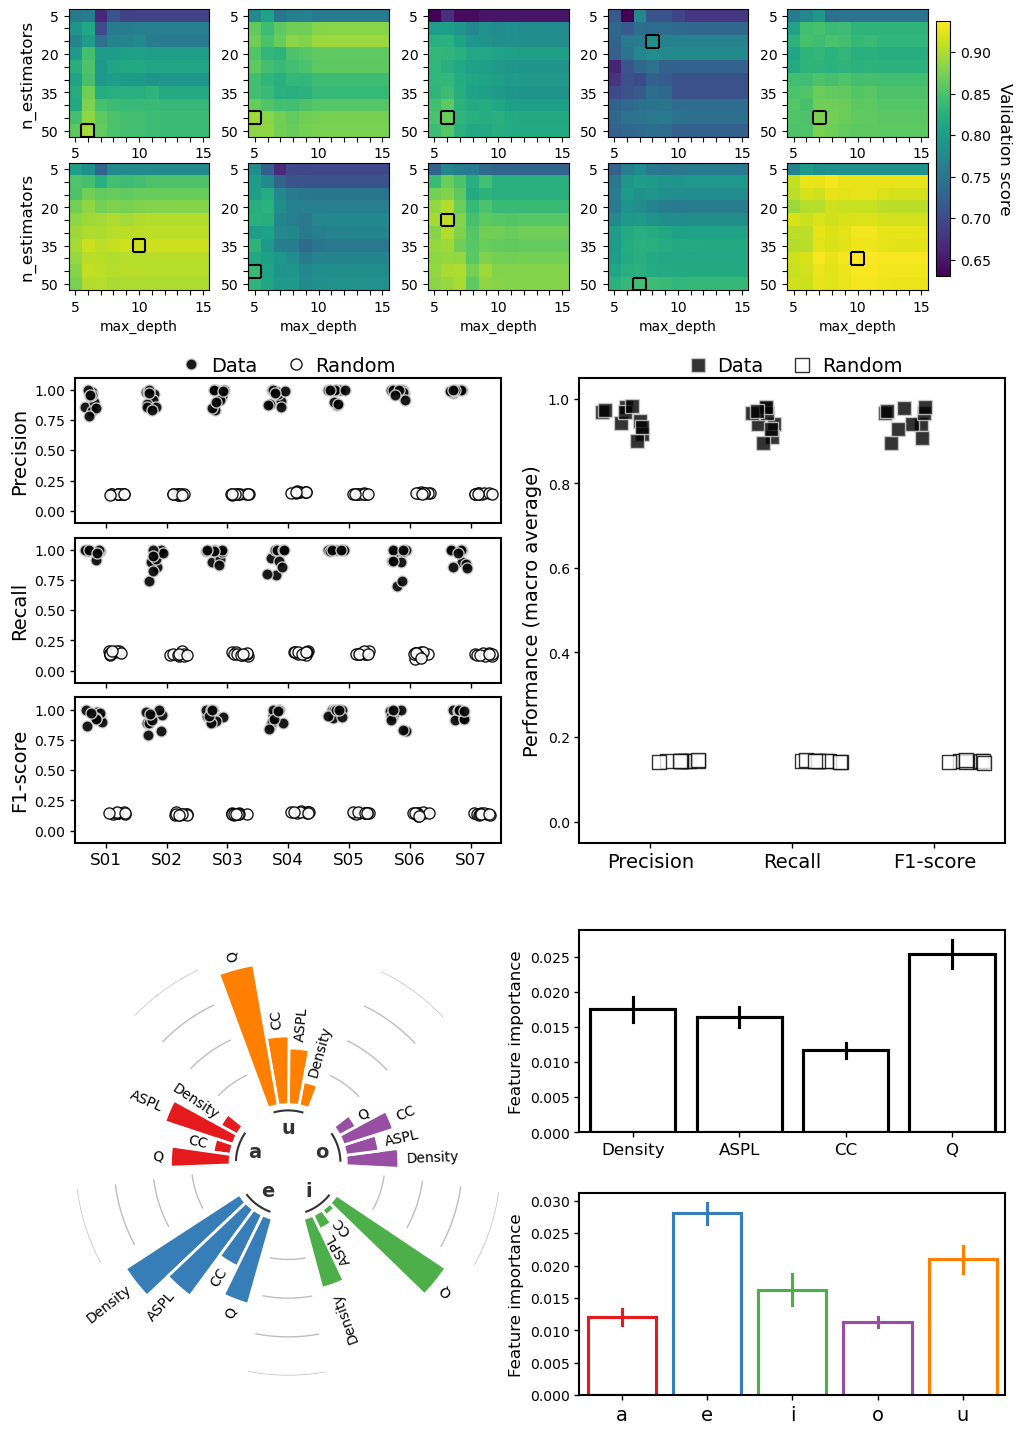

In [45]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

importance_name = 'Shap_test'
ratio_circ = 1800

seed = 2
np.random.seed(seed)
cmap_vowels = matplotlib.colormaps['Set1'].colors[:len(vowels)]
colors_vowels = [list(c) for c in np.vstack(np.array([[c]*len(features) for c in cmap_vowels]))]

fig = plt.figure(figsize=(12, 18))
outer = gridspec.GridSpec(nrows=8, ncols=10, wspace=3.5, hspace=0.9)


n_rows1 = 2
inner1 = gridspec.GridSpecFromSubplotSpec(n_rows1, int(M/n_rows1), subplot_spec=outer[0:2, 0:10],
                                          wspace=-0.15, hspace=0.2)
axs1 = []
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    df_results_rf = pd.read_csv(os.path.join(model_dir, 'df_results_rf.csv'), converters={'params': literal_eval})
    param_grid = {'n_estimators':  np.arange(5, 50+1, 5), 'max_depth': np.arange(5, 15+1)}
    selected_params = ['param_n_estimators', 'param_max_depth']
    best_params = df_results_rf['params'][np.argmax(df_results_rf['mean_test_score'])]
    labels_params = [p.split('param_')[1] for p in selected_params] #list(param_grid.keys())
    scores_matrix = df_results_rf.pivot(index=selected_params[0], columns=selected_params[1], values='mean_test_score')
    axs1.append(fig.add_subplot(inner1[m]))
    im = axs1[m].imshow(scores_matrix, vmin=min(scores_matrix_min), vmax=max(scores_matrix_max))
    axs1[m].set_yticks(np.arange(np.unique(df_results_rf[selected_params[0]]).size))
    yticklabels = ["{:.0f}".format(x) if (x-5)%15==0 else '' for x in np.unique(df_results_rf[selected_params[0]])]
    axs1[m].set_yticklabels(yticklabels)
    if np.divmod(m, int(M/n_rows1))[1] == 0:
        axs1[m].set_ylabel(labels_params[0], fontsize=12)
    else:
        axs1[m].set_ylabel('')
    axs1[m].set_xticks(np.arange(np.unique(df_results_rf[selected_params[1]]).size))
    xticklabels = ["{:.0f}".format(x) if (x-5)%5==0 else '' for x in np.unique(df_results_rf[selected_params[1]])]
    axs1[m].set_xticklabels(xticklabels)
    if np.divmod(m, int(M/n_rows1))[0] == 1:
        axs1[m].set_xlabel(labels_params[1], fontsize=12)
    else:
        axs1[m].set_xlabel('')
    axs1[m].set_xlabel(labels_params[1], fontsize=10)
    y1=np.where(param_grid[labels_params[0]] == best_params[labels_params[0]])[0][0]
    x1=np.where(param_grid[labels_params[1]] == best_params[labels_params[1]])[0][0]
    axs1[m].hlines(y=[y1-0.5, y1+0.5], xmin=x1-0.5, xmax=x1+0.5, colors='k', lw=1.5)
    axs1[m].vlines(x=[x1-0.5, x1+0.5], ymin=y1-0.5, ymax=y1+0.5, colors='k', lw=1.5)
    box = axs1[m].get_position()
    box.x0 = box.x0 - 0.035
    box.x1 = box.x1 - 0.035
    axs1[m].set_position(box)
axins = inset_axes(axs1[M-1],
                   width="10%",  # width = 5% of parent_bbox width
                   height="200%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.1, 1, 1),
                   bbox_transform=axs1[M-1].transAxes,
                   borderpad=0.1,
                   )
cbar = fig.colorbar(im, cax=axins)
cbar.set_label('Validation score', rotation=270, fontsize=12, labelpad=15)


performance_name = ['Precision', 'Recall', 'F1-score']
xtickslabels = ['S'+str(i).zfill(2) for i in np.arange(len(subject_names))+1]
fcolor = ['k', 'w']
ecolor = ['lightgray', 'k']
labels_dict = {'0': 'Data', '1': 'Random'}
n_rows4 = len(performance_name)
inner4 = gridspec.GridSpecFromSubplotSpec(n_rows4, 1, subplot_spec=outer[2:5, 0:5], hspace=0.1)
axs4 = []
for p in np.arange(len(performance_name)):
    df_tmp = df_performances[df_performances['Metric'] == performance_name[p]]
    axs4.append(fig.add_subplot(inner4[p]))
    sns.stripplot(data=df_tmp, x='Subjects', y='Values', hue='Random', size=8, marker="o",
                  dodge=True, jitter=0.3, alpha=.9, linewidth=0, legend=True, ax=axs4[p])
    e = 0
    l = 0
    for children in axs4[p].get_children():
        if 'Path' in str(children):
            children.set_linewidth(1)
            children.set_facecolor(fcolor[np.mod(e,2)])
            children.set_edgecolor(ecolor[np.mod(e,2)])
            e += 1
        if 'Line2D' in str(children):
            children.set_markerfacecolor(fcolor[np.mod(l,2)])
            children.set_markeredgecolor(ecolor[np.mod(l,2)])
            children.set_markeredgewidth(1)
            l += 1
    axs4[p].set_ylabel(performance_name[p], fontsize=14)
    axs4[p].set_xlabel('')
    axs4[p].set_ylim([0-0.1, 1+0.1])
    axs4[p].set_xticks(np.arange(len(subject_names)))
    if p < len(performance_name)-1:
        axs4[p].set_xticklabels([])
    else:
        axs4[p].set_xticklabels(xtickslabels)
    for axis in ['top','bottom','left','right']:
        axs4[p].spines[axis].set_linewidth(1.5)
    if p == 0:
        handles, labels_tmp = axs4[p].get_legend_handles_labels()
        labels = [labels_dict[label] for label in labels_tmp]
        positions = axs4[p].get_position()
        bbox = (positions.x0+0.125, positions.y0+0.15, positions.x1, positions.y1)
        axs4[p].legend(handles[:], labels[:], bbox_to_anchor=bbox, loc="center",
                       ncol=len(labels), columnspacing=1, handletextpad=0.01, frameon=False, fontsize=14)
    else:
        axs4[p].legend().set_visible(False)
    axs4[p].tick_params(width=1)
    axs4[p].tick_params(labelsize=10)
    axs4[p].tick_params(axis='x', labelsize=12)
    

performance_name = ['Precision', 'Recall', 'F1-score']
fcolor = ['k', 'w']
ecolor = ['lightgray', 'k']
labels_dict = {'0': 'Data', '1': 'Random'}
axs5 = fig.add_subplot(outer[2:5, 5:10])
sns.stripplot(data=df_performances_avg, x='Metric', y='Values', hue='Random', size=10, marker="s",
              dodge=True, jitter=0.3, alpha=.8, linewidth=0, legend=True, ax=axs5)
e = 0
l = 0
for children in axs5.get_children():
    if 'Path' in str(children):
        children.set_linewidth(1)
        children.set_facecolor(fcolor[np.mod(e,2)])
        children.set_edgecolor(ecolor[np.mod(e,2)])
        e += 1
    if 'Line2D' in str(children):
        children.set_markerfacecolor(fcolor[np.mod(l,2)])
        children.set_markeredgecolor(ecolor[np.mod(l,2)])
        children.set_markeredgewidth(1)
        l += 1
axs5.set_xticks(np.arange(len(performance_name)))
axs5.set_xticklabels(performance_name)
axs5.set_xlabel('')
axs5.set_ylim([0-0.05, 1+0.05])
axs5.set_ylabel('Performance (macro average)', fontsize=14)
for axis in ['top','bottom','left','right']:
    axs5.spines[axis].set_linewidth(1.5)
handles, labels_tmp = axs5.get_legend_handles_labels()
labels = [labels_dict[label] for label in labels_tmp]
positions = axs5.get_position()
bbox = (positions.x0-0.5, positions.y0+0.27, positions.x1, positions.y1)
axs5.legend(handles[:], labels[:], bbox_to_anchor=bbox, loc="center",
            ncol=len(labels), columnspacing=1, handletextpad=0.01, frameon=False, fontsize=14)
axs5.tick_params(width=1)
axs5.tick_params(labelsize=10)
axs5.tick_params(axis='x', labelsize=14)

axs2 = fig.add_subplot(outer[5:8, 0:5], polar=True)
df_tmp = df_importance.groupby(['Feature', 'Vowel'], sort=False, as_index=False)[importance_name].mean()
values = df_tmp[importance_name].values*ratio_circ
feature_labels = df_tmp['Feature'].values
vowel_group = df_tmp['Vowel'].values
pad = 3
# angles = np.linspace(0, 2*np.pi, num=len(values)+pad*len(np.unique(vowel_group)), endpoint=False)
angles = np.linspace(-np.pi/2, np.pi*3/2, num=len(values)+pad*len(np.unique(vowel_group)), endpoint=False)
width = (2*np.pi)/len(angles)
groups_size = [len(i[1]) for i in df_tmp.groupby('Vowel')]
offset = 0
idxs = []
for size in groups_size:
    idxs += list(range(offset+pad, offset+size+pad))
    offset += size+pad
axs2.set_theta_offset(offset)
axs2.set_ylim(-30, 80)
axs2.set_frame_on(False)
axs2.xaxis.grid(False)
axs2.yaxis.grid(False)
axs2.set_xticks([])
axs2.set_yticks([])
axs2.bar(angles[idxs], values, width=width, color=colors_vowels, edgecolor="white", linewidth=2)
add_labels(angles[idxs], values, feature_labels, offset, axs2)
offset = 0
for group, size in zip(vowels, groups_size):
    x1 = np.linspace(angles[offset+pad], angles[offset+size+pad-1], num=50)
    axs2.plot(x1, [-3] * 50, color="#333333")    
    axs2.text(np.mean(x1), -12, group, color="#333333", fontsize=14, fontweight="bold", ha="center", va="center")
    x2 = np.linspace(angles[offset], angles[offset+pad-1], num=50)
    axs2.plot(x2, [20] * 50, color="#bebebe", lw=1)
    axs2.plot(x2, [40] * 50, color="#bebebe", lw=1)
    axs2.plot(x2, [60] * 50, color="#bebebe", lw=1)
    axs2.plot(x2, [80] * 50, color="#bebebe", lw=1)
    offset += size+pad


n_rows3 = 2
group = ['Feature', 'Vowel']
isfill = [False, False]
xlabelsize = [12, 14]
# xticklabels3 = ['Diameter', 'Density', 'Path \n Length', 'Clustering \n Coefficient', 'Modularity']
inner3 = gridspec.GridSpecFromSubplotSpec(n_rows3, 1, subplot_spec=outer[5:8, 5:10], hspace=0.3)
axs3 = []
for i in range(n_rows3):
    axs3.append(fig.add_subplot(inner3[i]))
    if i==0:
        sns.barplot(data=df_importance, x=group[i], y=importance_name,
                    errorbar='se', fill=isfill[i], color='k', ax=axs3[i])
#         axs3[i].set_xticks(np.arange(len(xticklabels3)))
#         axs3[i].set_xticklabels(xticklabels3, fontsize=10)
    elif i==1:
        sns.barplot(data=df_importance, x=group[i], y=importance_name,
                    errorbar='se', fill=isfill[i], palette=cmap_vowels, ax=axs3[i])
    axs3[i].set_ylabel('Feature importance', fontsize=12)
    axs3[i].set_xlabel('')
    for axis in ['top','bottom','left','right']:
        axs3[i].spines[axis].set_linewidth(1.5)
    axs3[i].tick_params(width=1)
    axs3[i].tick_params(labelsize=10)
    axs3[i].tick_params(axis='x', labelsize=xlabelsize[i])

# fig.savefig(os.path.join(figures_dir, 'fig_models_rf_circular_shap.png'), format='png', dpi=300, facecolor='w')
# fig.savefig(os.path.join(figures_dir, 'fig_models_rf_circular_shap.pdf'), format='pdf', dpi=300, facecolor='w')

Shap kernel

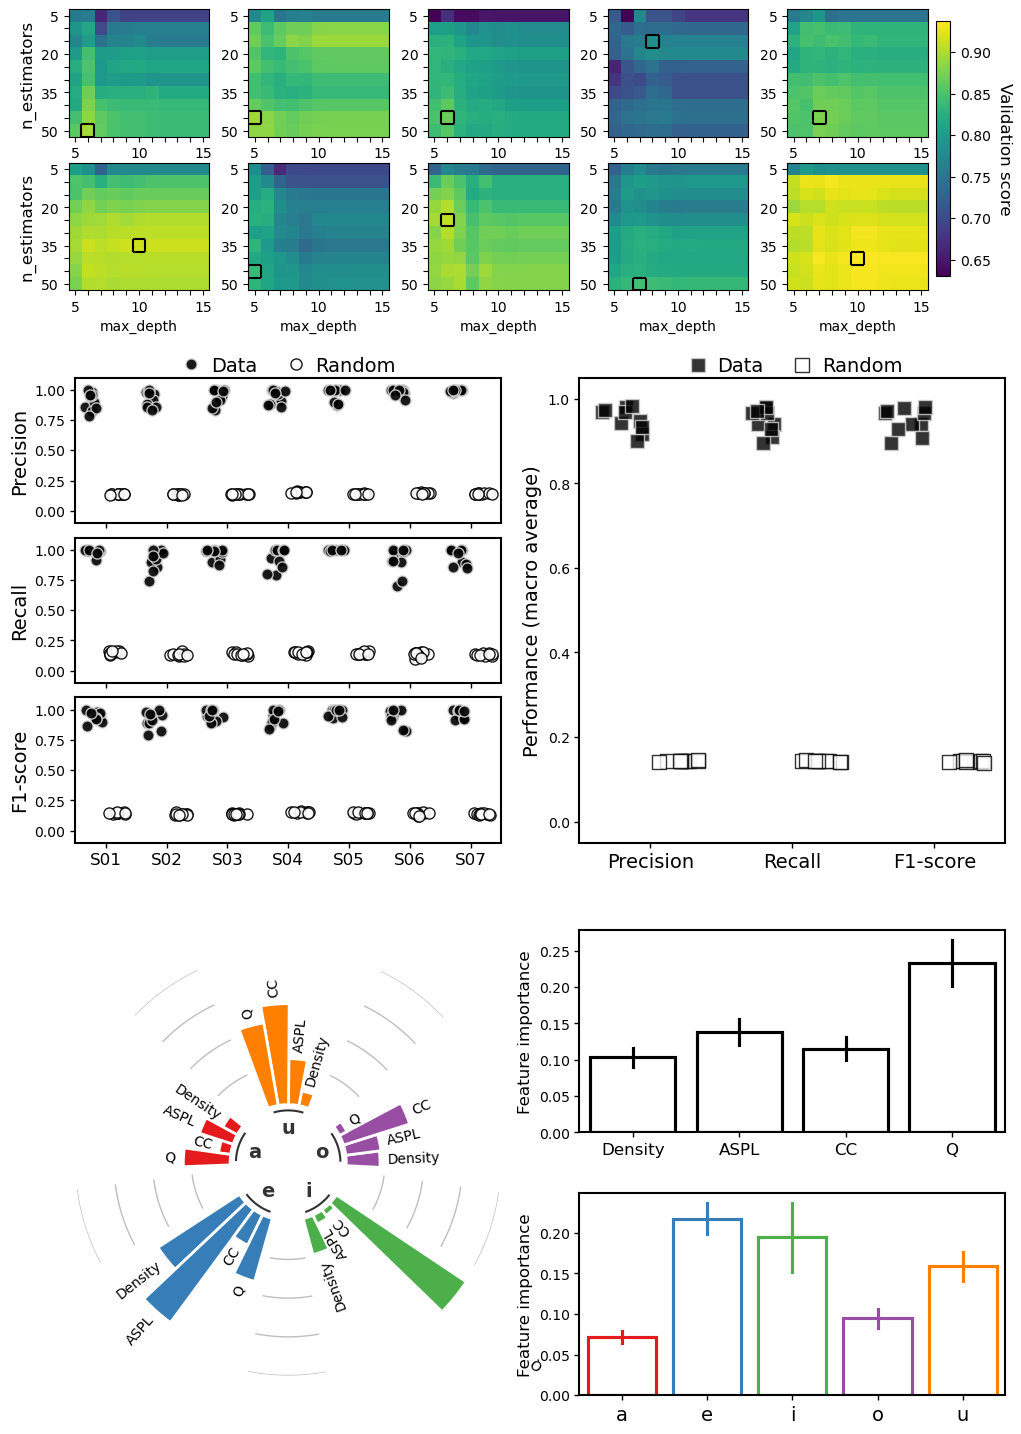

In [38]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

importance_name = 'Shap_test_kernel'
ratio_circ = 200

seed = 2
np.random.seed(seed)
cmap_vowels = matplotlib.colormaps['Set1'].colors[:len(vowels)]
colors_vowels = [list(c) for c in np.vstack(np.array([[c]*len(features) for c in cmap_vowels]))]

fig = plt.figure(figsize=(12, 18))
outer = gridspec.GridSpec(nrows=8, ncols=10, wspace=3.5, hspace=0.9)


n_rows1 = 2
inner1 = gridspec.GridSpecFromSubplotSpec(n_rows1, int(M/n_rows1), subplot_spec=outer[0:2, 0:10],
                                          wspace=-0.15, hspace=0.2)
axs1 = []
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    df_results_rf = pd.read_csv(os.path.join(model_dir, 'df_results_rf.csv'), converters={'params': literal_eval})
    param_grid = {'n_estimators':  np.arange(5, 50+1, 5), 'max_depth': np.arange(5, 15+1)}
    selected_params = ['param_n_estimators', 'param_max_depth']
    best_params = df_results_rf['params'][np.argmax(df_results_rf['mean_test_score'])]
    labels_params = [p.split('param_')[1] for p in selected_params] #list(param_grid.keys())
    scores_matrix = df_results_rf.pivot(index=selected_params[0], columns=selected_params[1], values='mean_test_score')
    axs1.append(fig.add_subplot(inner1[m]))
    im = axs1[m].imshow(scores_matrix, vmin=min(scores_matrix_min), vmax=max(scores_matrix_max))
    axs1[m].set_yticks(np.arange(np.unique(df_results_rf[selected_params[0]]).size))
    yticklabels = ["{:.0f}".format(x) if (x-5)%15==0 else '' for x in np.unique(df_results_rf[selected_params[0]])]
    axs1[m].set_yticklabels(yticklabels)
    if np.divmod(m, int(M/n_rows1))[1] == 0:
        axs1[m].set_ylabel(labels_params[0], fontsize=12)
    else:
        axs1[m].set_ylabel('')
    axs1[m].set_xticks(np.arange(np.unique(df_results_rf[selected_params[1]]).size))
    xticklabels = ["{:.0f}".format(x) if (x-5)%5==0 else '' for x in np.unique(df_results_rf[selected_params[1]])]
    axs1[m].set_xticklabels(xticklabels)
    if np.divmod(m, int(M/n_rows1))[0] == 1:
        axs1[m].set_xlabel(labels_params[1], fontsize=12)
    else:
        axs1[m].set_xlabel('')
    axs1[m].set_xlabel(labels_params[1], fontsize=10)
    y1=np.where(param_grid[labels_params[0]] == best_params[labels_params[0]])[0][0]
    x1=np.where(param_grid[labels_params[1]] == best_params[labels_params[1]])[0][0]
    axs1[m].hlines(y=[y1-0.5, y1+0.5], xmin=x1-0.5, xmax=x1+0.5, colors='k', lw=1.5)
    axs1[m].vlines(x=[x1-0.5, x1+0.5], ymin=y1-0.5, ymax=y1+0.5, colors='k', lw=1.5)
    box = axs1[m].get_position()
    box.x0 = box.x0 - 0.035
    box.x1 = box.x1 - 0.035
    axs1[m].set_position(box)
axins = inset_axes(axs1[M-1],
                   width="10%",  # width = 5% of parent_bbox width
                   height="200%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.1, 1, 1),
                   bbox_transform=axs1[M-1].transAxes,
                   borderpad=0.1,
                   )
cbar = fig.colorbar(im, cax=axins)
cbar.set_label('Validation score', rotation=270, fontsize=12, labelpad=15)


performance_name = ['Precision', 'Recall', 'F1-score']
xtickslabels = ['S'+str(i).zfill(2) for i in np.arange(len(subject_names))+1]
fcolor = ['k', 'w']
ecolor = ['lightgray', 'k']
labels_dict = {'0': 'Data', '1': 'Random'}
n_rows4 = len(performance_name)
inner4 = gridspec.GridSpecFromSubplotSpec(n_rows4, 1, subplot_spec=outer[2:5, 0:5], hspace=0.1)
axs4 = []
for p in np.arange(len(performance_name)):
    df_tmp = df_performances[df_performances['Metric'] == performance_name[p]]
    axs4.append(fig.add_subplot(inner4[p]))
    sns.stripplot(data=df_tmp, x='Subjects', y='Values', hue='Random', size=8, marker="o",
                  dodge=True, jitter=0.3, alpha=.9, linewidth=0, legend=True, ax=axs4[p])
    e = 0
    l = 0
    for children in axs4[p].get_children():
        if 'Path' in str(children):
            children.set_linewidth(1)
            children.set_facecolor(fcolor[np.mod(e,2)])
            children.set_edgecolor(ecolor[np.mod(e,2)])
            e += 1
        if 'Line2D' in str(children):
            children.set_markerfacecolor(fcolor[np.mod(l,2)])
            children.set_markeredgecolor(ecolor[np.mod(l,2)])
            children.set_markeredgewidth(1)
            l += 1
    axs4[p].set_ylabel(performance_name[p], fontsize=14)
    axs4[p].set_xlabel('')
    axs4[p].set_ylim([0-0.1, 1+0.1])
    axs4[p].set_xticks(np.arange(len(subject_names)))
    if p < len(performance_name)-1:
        axs4[p].set_xticklabels([])
    else:
        axs4[p].set_xticklabels(xtickslabels)
    for axis in ['top','bottom','left','right']:
        axs4[p].spines[axis].set_linewidth(1.5)
    if p == 0:
        handles, labels_tmp = axs4[p].get_legend_handles_labels()
        labels = [labels_dict[label] for label in labels_tmp]
        positions = axs4[p].get_position()
        bbox = (positions.x0+0.125, positions.y0+0.15, positions.x1, positions.y1)
        axs4[p].legend(handles[:], labels[:], bbox_to_anchor=bbox, loc="center",
                       ncol=len(labels), columnspacing=1, handletextpad=0.01, frameon=False, fontsize=14)
    else:
        axs4[p].legend().set_visible(False)
    axs4[p].tick_params(width=1)
    axs4[p].tick_params(labelsize=10)
    axs4[p].tick_params(axis='x', labelsize=12)
    

performance_name = ['Precision', 'Recall', 'F1-score']
fcolor = ['k', 'w']
ecolor = ['lightgray', 'k']
labels_dict = {'0': 'Data', '1': 'Random'}
axs5 = fig.add_subplot(outer[2:5, 5:10])
sns.stripplot(data=df_performances_avg, x='Metric', y='Values', hue='Random', size=10, marker="s",
              dodge=True, jitter=0.3, alpha=.8, linewidth=0, legend=True, ax=axs5)
e = 0
l = 0
for children in axs5.get_children():
    if 'Path' in str(children):
        children.set_linewidth(1)
        children.set_facecolor(fcolor[np.mod(e,2)])
        children.set_edgecolor(ecolor[np.mod(e,2)])
        e += 1
    if 'Line2D' in str(children):
        children.set_markerfacecolor(fcolor[np.mod(l,2)])
        children.set_markeredgecolor(ecolor[np.mod(l,2)])
        children.set_markeredgewidth(1)
        l += 1
axs5.set_xticks(np.arange(len(performance_name)))
axs5.set_xticklabels(performance_name)
axs5.set_xlabel('')
axs5.set_ylim([0-0.05, 1+0.05])
axs5.set_ylabel('Performance (macro average)', fontsize=14)
for axis in ['top','bottom','left','right']:
    axs5.spines[axis].set_linewidth(1.5)
handles, labels_tmp = axs5.get_legend_handles_labels()
labels = [labels_dict[label] for label in labels_tmp]
positions = axs5.get_position()
bbox = (positions.x0-0.5, positions.y0+0.27, positions.x1, positions.y1)
axs5.legend(handles[:], labels[:], bbox_to_anchor=bbox, loc="center",
            ncol=len(labels), columnspacing=1, handletextpad=0.01, frameon=False, fontsize=14)
axs5.tick_params(width=1)
axs5.tick_params(labelsize=10)
axs5.tick_params(axis='x', labelsize=14)

axs2 = fig.add_subplot(outer[5:8, 0:5], polar=True)
df_tmp = df_importance.groupby(['Feature', 'Vowel'], sort=False, as_index=False)[importance_name].mean()
values = df_tmp[importance_name].values*ratio_circ
feature_labels = df_tmp['Feature'].values
vowel_group = df_tmp['Vowel'].values
pad = 3
# angles = np.linspace(0, 2*np.pi, num=len(values)+pad*len(np.unique(vowel_group)), endpoint=False)
angles = np.linspace(-np.pi/2, np.pi*3/2, num=len(values)+pad*len(np.unique(vowel_group)), endpoint=False)
width = (2*np.pi)/len(angles)
groups_size = [len(i[1]) for i in df_tmp.groupby('Vowel')]
offset = 0
idxs = []
for size in groups_size:
    idxs += list(range(offset+pad, offset+size+pad))
    offset += size+pad
axs2.set_theta_offset(offset)
axs2.set_ylim(-30, 80)
axs2.set_frame_on(False)
axs2.xaxis.grid(False)
axs2.yaxis.grid(False)
axs2.set_xticks([])
axs2.set_yticks([])
axs2.bar(angles[idxs], values, width=width, color=colors_vowels, edgecolor="white", linewidth=2)
add_labels(angles[idxs], values, feature_labels, offset, axs2)
offset = 0
for group, size in zip(vowels, groups_size):
    x1 = np.linspace(angles[offset+pad], angles[offset+size+pad-1], num=50)
    axs2.plot(x1, [-3] * 50, color="#333333")    
    axs2.text(np.mean(x1), -12, group, color="#333333", fontsize=14, fontweight="bold", ha="center", va="center")
    x2 = np.linspace(angles[offset], angles[offset+pad-1], num=50)
    axs2.plot(x2, [20] * 50, color="#bebebe", lw=1)
    axs2.plot(x2, [40] * 50, color="#bebebe", lw=1)
    axs2.plot(x2, [60] * 50, color="#bebebe", lw=1)
    axs2.plot(x2, [80] * 50, color="#bebebe", lw=1)
    offset += size+pad


n_rows3 = 2
group = ['Feature', 'Vowel']
isfill = [False, False]
xlabelsize = [12, 14]
# xticklabels3 = ['Diameter', 'Density', 'Path \n Length', 'Clustering \n Coefficient', 'Modularity']
inner3 = gridspec.GridSpecFromSubplotSpec(n_rows3, 1, subplot_spec=outer[5:8, 5:10], hspace=0.3)
axs3 = []
for i in range(n_rows3):
    axs3.append(fig.add_subplot(inner3[i]))
    if i==0:
        sns.barplot(data=df_importance, x=group[i], y=importance_name,
                    errorbar='se', fill=isfill[i], color='k', ax=axs3[i])
#         axs3[i].set_xticks(np.arange(len(xticklabels3)))
#         axs3[i].set_xticklabels(xticklabels3, fontsize=10)
    elif i==1:
        sns.barplot(data=df_importance, x=group[i], y=importance_name,
                    errorbar='se', fill=isfill[i], palette=cmap_vowels, ax=axs3[i])
    axs3[i].set_ylabel('Feature importance', fontsize=12)
    axs3[i].set_xlabel('')
    for axis in ['top','bottom','left','right']:
        axs3[i].spines[axis].set_linewidth(1.5)
    axs3[i].tick_params(width=1)
    axs3[i].tick_params(labelsize=10)
    axs3[i].tick_params(axis='x', labelsize=xlabelsize[i])

# fig.savefig(os.path.join(figures_dir, 'fig_models_rf_circular_shap_kernel.png'), format='png', dpi=300, facecolor='w')
# fig.savefig(os.path.join(figures_dir, 'fig_models_rf_circular_shap_kernel.pdf'), format='pdf', dpi=300, facecolor='w')

Permutation

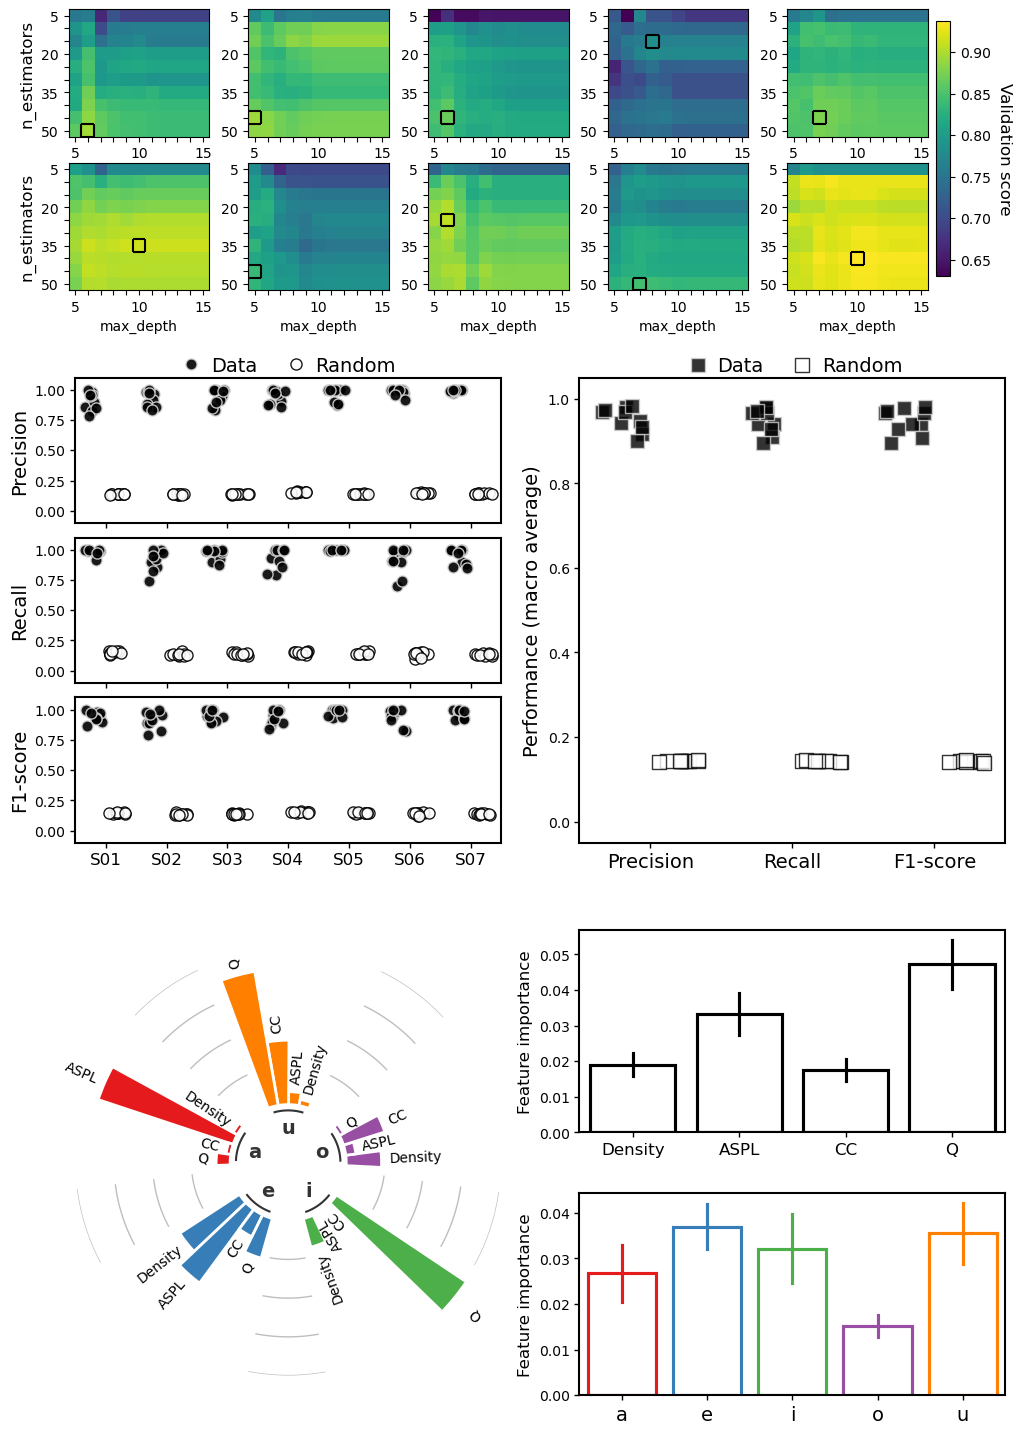

In [46]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

importance_name = 'Permutation_test'
ratio_circ = 800

seed = 2
np.random.seed(seed)
cmap_vowels = matplotlib.colormaps['Set1'].colors[:len(vowels)]
colors_vowels = [list(c) for c in np.vstack(np.array([[c]*len(features) for c in cmap_vowels]))]

fig = plt.figure(figsize=(12, 18))
outer = gridspec.GridSpec(nrows=8, ncols=10, wspace=3.5, hspace=0.9)


n_rows1 = 2
inner1 = gridspec.GridSpecFromSubplotSpec(n_rows1, int(M/n_rows1), subplot_spec=outer[0:2, 0:10],
                                          wspace=-0.15, hspace=0.2)
axs1 = []
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    df_results_rf = pd.read_csv(os.path.join(model_dir, 'df_results_rf.csv'), converters={'params': literal_eval})
    param_grid = {'n_estimators':  np.arange(5, 50+1, 5), 'max_depth': np.arange(5, 15+1)}
    selected_params = ['param_n_estimators', 'param_max_depth']
    best_params = df_results_rf['params'][np.argmax(df_results_rf['mean_test_score'])]
    labels_params = [p.split('param_')[1] for p in selected_params] #list(param_grid.keys())
    scores_matrix = df_results_rf.pivot(index=selected_params[0], columns=selected_params[1], values='mean_test_score')
    axs1.append(fig.add_subplot(inner1[m]))
    im = axs1[m].imshow(scores_matrix, vmin=min(scores_matrix_min), vmax=max(scores_matrix_max))
    axs1[m].set_yticks(np.arange(np.unique(df_results_rf[selected_params[0]]).size))
    yticklabels = ["{:.0f}".format(x) if (x-5)%15==0 else '' for x in np.unique(df_results_rf[selected_params[0]])]
    axs1[m].set_yticklabels(yticklabels)
    if np.divmod(m, int(M/n_rows1))[1] == 0:
        axs1[m].set_ylabel(labels_params[0], fontsize=12)
    else:
        axs1[m].set_ylabel('')
    axs1[m].set_xticks(np.arange(np.unique(df_results_rf[selected_params[1]]).size))
    xticklabels = ["{:.0f}".format(x) if (x-5)%5==0 else '' for x in np.unique(df_results_rf[selected_params[1]])]
    axs1[m].set_xticklabels(xticklabels)
    if np.divmod(m, int(M/n_rows1))[0] == 1:
        axs1[m].set_xlabel(labels_params[1], fontsize=12)
    else:
        axs1[m].set_xlabel('')
    axs1[m].set_xlabel(labels_params[1], fontsize=10)
    y1=np.where(param_grid[labels_params[0]] == best_params[labels_params[0]])[0][0]
    x1=np.where(param_grid[labels_params[1]] == best_params[labels_params[1]])[0][0]
    axs1[m].hlines(y=[y1-0.5, y1+0.5], xmin=x1-0.5, xmax=x1+0.5, colors='k', lw=1.5)
    axs1[m].vlines(x=[x1-0.5, x1+0.5], ymin=y1-0.5, ymax=y1+0.5, colors='k', lw=1.5)
    box = axs1[m].get_position()
    box.x0 = box.x0 - 0.035
    box.x1 = box.x1 - 0.035
    axs1[m].set_position(box)
axins = inset_axes(axs1[M-1],
                   width="10%",  # width = 5% of parent_bbox width
                   height="200%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.1, 1, 1),
                   bbox_transform=axs1[M-1].transAxes,
                   borderpad=0.1,
                   )
cbar = fig.colorbar(im, cax=axins)
cbar.set_label('Validation score', rotation=270, fontsize=12, labelpad=15)


performance_name = ['Precision', 'Recall', 'F1-score']
xtickslabels = ['S'+str(i).zfill(2) for i in np.arange(len(subject_names))+1]
fcolor = ['k', 'w']
ecolor = ['lightgray', 'k']
labels_dict = {'0': 'Data', '1': 'Random'}
n_rows4 = len(performance_name)
inner4 = gridspec.GridSpecFromSubplotSpec(n_rows4, 1, subplot_spec=outer[2:5, 0:5], hspace=0.1)
axs4 = []
for p in np.arange(len(performance_name)):
    df_tmp = df_performances[df_performances['Metric'] == performance_name[p]]
    axs4.append(fig.add_subplot(inner4[p]))
    sns.stripplot(data=df_tmp, x='Subjects', y='Values', hue='Random', size=8, marker="o",
                  dodge=True, jitter=0.3, alpha=.9, linewidth=0, legend=True, ax=axs4[p])
    e = 0
    l = 0
    for children in axs4[p].get_children():
        if 'Path' in str(children):
            children.set_linewidth(1)
            children.set_facecolor(fcolor[np.mod(e,2)])
            children.set_edgecolor(ecolor[np.mod(e,2)])
            e += 1
        if 'Line2D' in str(children):
            children.set_markerfacecolor(fcolor[np.mod(l,2)])
            children.set_markeredgecolor(ecolor[np.mod(l,2)])
            children.set_markeredgewidth(1)
            l += 1
    axs4[p].set_ylabel(performance_name[p], fontsize=14)
    axs4[p].set_xlabel('')
    axs4[p].set_ylim([0-0.1, 1+0.1])
    axs4[p].set_xticks(np.arange(len(subject_names)))
    if p < len(performance_name)-1:
        axs4[p].set_xticklabels([])
    else:
        axs4[p].set_xticklabels(xtickslabels)
    for axis in ['top','bottom','left','right']:
        axs4[p].spines[axis].set_linewidth(1.5)
    if p == 0:
        handles, labels_tmp = axs4[p].get_legend_handles_labels()
        labels = [labels_dict[label] for label in labels_tmp]
        positions = axs4[p].get_position()
        bbox = (positions.x0+0.125, positions.y0+0.15, positions.x1, positions.y1)
        axs4[p].legend(handles[:], labels[:], bbox_to_anchor=bbox, loc="center",
                       ncol=len(labels), columnspacing=1, handletextpad=0.01, frameon=False, fontsize=14)
    else:
        axs4[p].legend().set_visible(False)
    axs4[p].tick_params(width=1)
    axs4[p].tick_params(labelsize=10)
    axs4[p].tick_params(axis='x', labelsize=12)
    

performance_name = ['Precision', 'Recall', 'F1-score']
fcolor = ['k', 'w']
ecolor = ['lightgray', 'k']
labels_dict = {'0': 'Data', '1': 'Random'}
axs5 = fig.add_subplot(outer[2:5, 5:10])
sns.stripplot(data=df_performances_avg, x='Metric', y='Values', hue='Random', size=10, marker="s",
              dodge=True, jitter=0.3, alpha=.8, linewidth=0, legend=True, ax=axs5)
e = 0
l = 0
for children in axs5.get_children():
    if 'Path' in str(children):
        children.set_linewidth(1)
        children.set_facecolor(fcolor[np.mod(e,2)])
        children.set_edgecolor(ecolor[np.mod(e,2)])
        e += 1
    if 'Line2D' in str(children):
        children.set_markerfacecolor(fcolor[np.mod(l,2)])
        children.set_markeredgecolor(ecolor[np.mod(l,2)])
        children.set_markeredgewidth(1)
        l += 1
axs5.set_xticks(np.arange(len(performance_name)))
axs5.set_xticklabels(performance_name)
axs5.set_xlabel('')
axs5.set_ylim([0-0.05, 1+0.05])
axs5.set_ylabel('Performance (macro average)', fontsize=14)
for axis in ['top','bottom','left','right']:
    axs5.spines[axis].set_linewidth(1.5)
handles, labels_tmp = axs5.get_legend_handles_labels()
labels = [labels_dict[label] for label in labels_tmp]
positions = axs5.get_position()
bbox = (positions.x0-0.5, positions.y0+0.27, positions.x1, positions.y1)
axs5.legend(handles[:], labels[:], bbox_to_anchor=bbox, loc="center",
            ncol=len(labels), columnspacing=1, handletextpad=0.01, frameon=False, fontsize=14)
axs5.tick_params(width=1)
axs5.tick_params(labelsize=10)
axs5.tick_params(axis='x', labelsize=14)

axs2 = fig.add_subplot(outer[5:8, 0:5], polar=True)
df_tmp = df_importance.groupby(['Feature', 'Vowel'], sort=False, as_index=False)[importance_name].mean()
values = df_tmp[importance_name].values*ratio_circ
feature_labels = df_tmp['Feature'].values
vowel_group = df_tmp['Vowel'].values
pad = 3
# angles = np.linspace(0, 2*np.pi, num=len(values)+pad*len(np.unique(vowel_group)), endpoint=False)
angles = np.linspace(-np.pi/2, np.pi*3/2, num=len(values)+pad*len(np.unique(vowel_group)), endpoint=False)
width = (2*np.pi)/len(angles)
groups_size = [len(i[1]) for i in df_tmp.groupby('Vowel')]
offset = 0
idxs = []
for size in groups_size:
    idxs += list(range(offset+pad, offset+size+pad))
    offset += size+pad
axs2.set_theta_offset(offset)
axs2.set_ylim(-30, 80)
axs2.set_frame_on(False)
axs2.xaxis.grid(False)
axs2.yaxis.grid(False)
axs2.set_xticks([])
axs2.set_yticks([])
axs2.bar(angles[idxs], values, width=width, color=colors_vowels, edgecolor="white", linewidth=2)
add_labels(angles[idxs], values, feature_labels, offset, axs2)
offset = 0
for group, size in zip(vowels, groups_size):
    x1 = np.linspace(angles[offset+pad], angles[offset+size+pad-1], num=50)
    axs2.plot(x1, [-3] * 50, color="#333333")    
    axs2.text(np.mean(x1), -12, group, color="#333333", fontsize=14, fontweight="bold", ha="center", va="center")
    x2 = np.linspace(angles[offset], angles[offset+pad-1], num=50)
    axs2.plot(x2, [20] * 50, color="#bebebe", lw=1)
    axs2.plot(x2, [40] * 50, color="#bebebe", lw=1)
    axs2.plot(x2, [60] * 50, color="#bebebe", lw=1)
    axs2.plot(x2, [80] * 50, color="#bebebe", lw=1)
    offset += size+pad


n_rows3 = 2
group = ['Feature', 'Vowel']
isfill = [False, False]
xlabelsize = [12, 14]
# xticklabels3 = ['Diameter', 'Density', 'Path \n Length', 'Clustering \n Coefficient', 'Modularity']
inner3 = gridspec.GridSpecFromSubplotSpec(n_rows3, 1, subplot_spec=outer[5:8, 5:10], hspace=0.3)
axs3 = []
for i in range(n_rows3):
    axs3.append(fig.add_subplot(inner3[i]))
    if i==0:
        sns.barplot(data=df_importance, x=group[i], y=importance_name,
                    errorbar='se', fill=isfill[i], color='k', ax=axs3[i])
#         axs3[i].set_xticks(np.arange(len(xticklabels3)))
#         axs3[i].set_xticklabels(xticklabels3, fontsize=10)
    elif i==1:
        sns.barplot(data=df_importance, x=group[i], y=importance_name,
                    errorbar='se', fill=isfill[i], palette=cmap_vowels, ax=axs3[i])
    axs3[i].set_ylabel('Feature importance', fontsize=12)
    axs3[i].set_xlabel('')
    for axis in ['top','bottom','left','right']:
        axs3[i].spines[axis].set_linewidth(1.5)
    axs3[i].tick_params(width=1)
    axs3[i].tick_params(labelsize=10)
    axs3[i].tick_params(axis='x', labelsize=xlabelsize[i])

# fig.savefig(os.path.join(figures_dir, 'fig_models_rf_circular_permutation.png'), format='png', dpi=300, facecolor='w')
# fig.savefig(os.path.join(figures_dir, 'fig_models_rf_circular_permutation.pdf'), format='pdf', dpi=300, facecolor='w')

Features Correlations

In [74]:
N_features = 1000
corr_tensor = np.zeros((M, len(vowels)*df_metrics_subset.iloc[:,4:].shape[1],
                        len(vowels)*df_metrics_subset.iloc[:,4:].shape[1]))
for m in np.arange(M):
    model_dir = os.path.join(variables_dir, 'models', 'order_'+str(order), 'model_'+str(m+1).zfill(2))
    df_train = pd.read_csv(os.path.join(model_dir, 'df_train.csv'))
    sfiles = [eval(a) for a in df_train['Files']]
    sfiles_train = [eval(a) for a in df_train['Files_train']]
    sfiles_val = [eval(a) for a in df_train['Files_val']]
    sfiles_test = [eval(a) for a in df_train['Files_test']]
    indices_train = np.loadtxt(os.path.join(model_dir, 'indices_train.txt'), dtype ='int')
    indices_val = np.loadtxt(os.path.join(model_dir, 'indices_val.txt'), dtype ='int')
    indices_test = np.loadtxt(os.path.join(model_dir, 'indices_test.txt'), dtype ='int')
    y_subjects = sum([[s]*N_features for s in subject_names], [])
    subject2label_dict = dict(zip(subject_names, list(np.arange(len(subject_names)))))
    y = np.array([subject2label_dict[s] for s in y_subjects])
    y_train = y
    y_val = y
    y_test = y
    X_train = np.zeros((len(subject_names)*N_features, len(vowels)*df_metrics_subset.iloc[:,4:].shape[1]))
    X_val = np.zeros((len(subject_names)*N_features, len(vowels)*df_metrics_subset.iloc[:,4:].shape[1]))
    X_test = np.zeros((len(subject_names)*N_features, len(vowels)*df_metrics_subset.iloc[:,4:].shape[1]))
    e = 0
    for s in np.arange(len(subject_names)):
        df_tmp = df_metrics_subset[df_metrics_subset['Speaker'] == subject_names[s]]
        afiles = sfiles[s]
        afiles_train = sfiles_train[s]
        afiles_val = sfiles_val[s]
        afiles_test = sfiles_test[s]
        for n in np.arange(N_features):
            row_train = []
            row_val = []
            row_test = []
            for v in np.arange(len(vowels)):
                vfiles_train = [f for f in sfiles_train[s] if vowels[v] in f[:-4]]
                vfiles_val = [f for f in sfiles_val[s] if vowels[v] in f[:-4]]
                vfiles_test = [f for f in sfiles_test[s] if vowels[v] in f[:-4]]
                vfile_train = vfiles_train[indices_train[e, v]]
                vfile_val = vfiles_val[indices_val[e, v]]
                vfile_test = vfiles_test[indices_test[e, v]]
                row_train = np.append(row_train, df_tmp[(df_tmp['Vowel'] == vowels[v])&
                                                        (df_tmp['File'] == vfile_train)].iloc[:,4:].values)
                row_val = np.append(row_val, df_tmp[(df_tmp['Vowel'] == vowels[v])&
                                                    (df_tmp['File'] == vfile_val)].iloc[:,4:].values)
                row_test = np.append(row_test, df_tmp[(df_tmp['Vowel'] == vowels[v])&
                                                      (df_tmp['File'] == vfile_test)].iloc[:,4:].values)
            X_train[e, :] = np.hstack(row_train)
            X_val[e, :] = np.hstack(row_val)
            X_test[e, :] = np.hstack(row_test)
            e = e + 1
    X_train_combined = np.concatenate((X_train, X_val), axis=0)
    y_train_combined = np.concatenate((y_train, y_val), axis=0)

    corr_tensor[m] = np.corrcoef(X_train_combined.T)

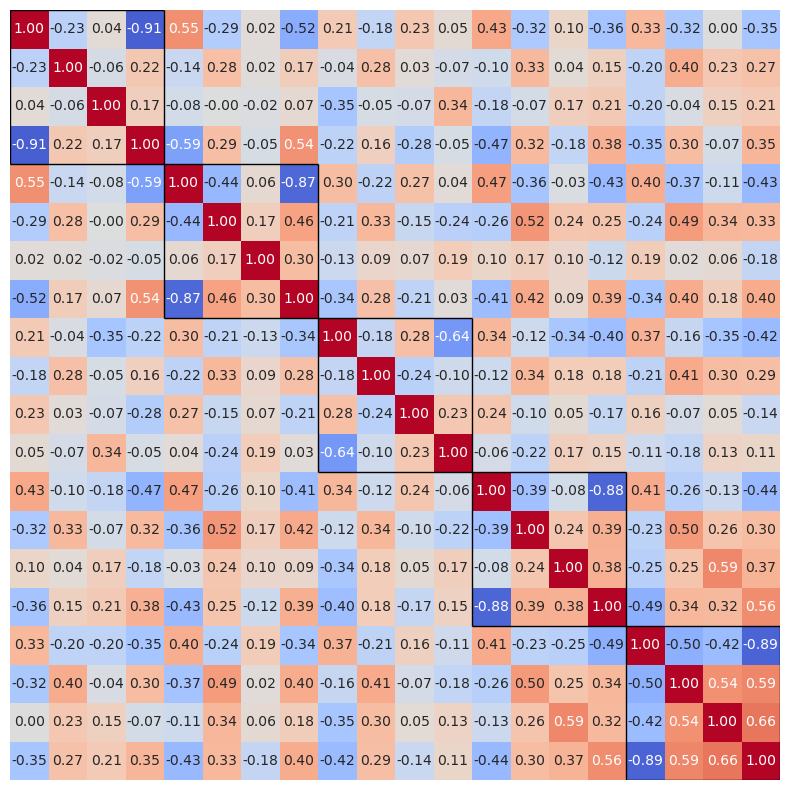

In [85]:
corr_tensor_mean = corr_tensor.mean(axis=0)

starts = np.arange(0, len(features)*len(vowels), len(features))
ends = np.arange(len(features), len(features)*len(vowels)+1, len(features))
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.heatmap(corr_tensor_mean, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt='.2f', cbar=False, ax=ax)
ax.set_xticks([]);
ax.set_yticks([]);
for i in np.arange(len(starts)):
    ax.hlines(y=starts[i], xmin=starts[i], xmax=ends[i], colors='k', lw=1)
    ax.hlines(y=ends[i], xmin=starts[i], xmax=ends[i], colors='k', lw=1)
    ax.vlines(x=starts[i], ymin=starts[i], ymax=ends[i], colors='k', lw=1)
    ax.vlines(x=ends[i], ymin=starts[i], ymax=ends[i], colors='k', lw=1)

plt.imshow(np.corrcoef(X_train_combined.T))

In [86]:
features

['Density', 'ASPL', 'CC', 'Q']

## Figure 5

Load performances

In [39]:
orders = np.arange(10,21)
accs =  np.array(())
precisions_avg = np.array(())
recalls_avg = np.array(())
f1scores_avg = np.array(())
for o in np.arange(len(orders)):
    order = orders[o]
    dir_order = os.path.join(results_order_dir, 'order_'+str(order))
    for m in np.arange(M):
        model_dir = os.path.join(dir_order, 'model_'+str(m+1).zfill(2))
        y_test = np.loadtxt(os.path.join(model_dir, 'y_test_rf.txt'), dtype='int')
        y_pred_test = np.loadtxt(os.path.join(model_dir, 'y_pred_test_rf.txt'), dtype='int')
#         print(sk.metrics.classification_report(y_test, y_pred_test))    
        (precision_avg, recall_avg, f1score_avg, _) = sk.metrics.precision_recall_fscore_support(y_true=y_test,
                                                                                                 y_pred=y_pred_test,
                                                                                                 average='macro')
        accs =  np.append(accs, sk.metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test))
        precisions_avg = np.append(precisions_avg, precision_avg)
        recalls_avg = np.append(recalls_avg, recall_avg)
        f1scores_avg = np.append(f1scores_avg, f1score_avg)

In [40]:
orders = np.arange(10,21)
accs_random =  np.array(())
precisions_avg_random = np.array(())
recalls_avg_random = np.array(())
f1scores_avg_random = np.array(())
for o in np.arange(len(orders)):
    order = orders[o]
    dir_order = os.path.join(results_order_dir, 'order_'+str(order))
    for m in np.arange(M):
        model_dir = os.path.join(dir_order, 'model_'+str(m+1).zfill(2))
        y_test = np.loadtxt(os.path.join(model_dir, 'y_test_rf.txt'), dtype='int')
        y_test_random = np.random.RandomState(seed=0).permutation(y_test)
        y_pred_test = np.loadtxt(os.path.join(model_dir, 'y_pred_test_rf.txt'), dtype='int')
#         print(sk.metrics.classification_report(y_test, y_pred_test))
        (precision_avg, recall_avg, f1score_avg, _) = sk.metrics.precision_recall_fscore_support(y_true=y_test_random,
                                                                                                 y_pred=y_pred_test,
                                                                                                 average='macro')
        accs_random =  np.append(accs_random, sk.metrics.accuracy_score(y_true=y_test_random,
                                                                        y_pred=y_pred_test))
        precisions_avg_random = np.append(precisions_avg_random, precision_avg)
        recalls_avg_random = np.append(recalls_avg_random, recall_avg)
        f1scores_avg_random = np.append(f1scores_avg_random, f1score_avg)

In [41]:
df_order = pd.DataFrame({'Model': list(np.arange(M)+1)*len(orders)*3*2,
                         'Order': np.hstack(np.array([[o]*M for o in orders]*3*2)),
                         'Metric': ['Precision']*precisions_avg.shape[0]+
                         ['Recall']*recalls_avg.shape[0]+
                         ['F1-score']*f1scores_avg.shape[0]+
                         ['Precision']*precisions_avg.shape[0]+
                         ['Recall']*recalls_avg.shape[0]+
                         ['F1-score']*f1scores_avg.shape[0],
                         'Random': [0]*precisions_avg.shape[0]*3+[1]*precisions_avg.shape[0]*3,
                         'Values': np.hstack((precisions_avg, recalls_avg, f1scores_avg,
                                              precisions_avg_random, recalls_avg_random, f1scores_avg_random))})

In [42]:
performance_name = ['Precision', 'Recall', 'F1-score']
pvalues_orders = []
for p in np.arange(len(performance_name)):
    df_tmp = df_order[df_order['Metric'] == performance_name[p]]
    performance_matrix = df_tmp[df_tmp['Random'] == 0]['Values'].ravel().reshape(len(orders), M)
    pvalues_tmp = []
    hip = []
    for o in np.arange(len(orders)):
        order = orders[o]
        x = performance_matrix[o]
        y = performance_matrix[orders==13][0]
    #     print(sp.stats.shapiro(x).pvalue, sp.stats.levene(x, y).pvalue)
        hip.append([sp.stats.shapiro(x).pvalue, sp.stats.levene(x, y).pvalue])
#         pvalues_tmp.append(sp.stats.ttest_ind(x, y).pvalue)
        pvalues_tmp.append(sp.stats.ranksums(x, y).pvalue)
    pvalues_orders.append(pvalues_tmp)
    hip = np.array(hip)
    if sum(np.sum(hip < 0.05, axis=0)) == 0:
        print('No rechaza las hipótesis')
    else: 
        print('Rechaza las hipótesis')
pvalues_orders = np.array(pvalues_orders)

Rechaza las hipótesis
Rechaza las hipótesis
Rechaza las hipótesis


In [43]:
thresholds = np.arange(0.5, 0.95+0.01, 0.05)
# orders = np.arange(10,21)
orders_th = [13]
accs =  np.array(())
precisions_avg = np.array(())
recalls_avg = np.array(())
f1scores_avg = np.array(())
for o in np.arange(len(orders_th)):
    order = orders_th[o]
    dir_order = os.path.join(results_threshold_dir, 'order_'+str(order))
    for t in np.arange(len(thresholds)):
        th = round(thresholds[t], 2)
        dir_threshold = os.path.join(dir_order, 'th_'+str(round(th, 2)))
        for m in np.arange(M):
            model_dir = os.path.join(dir_threshold, 'model_'+str(m+1).zfill(2))
            y_test = np.loadtxt(os.path.join(model_dir, 'y_test_rf.txt'), dtype='int')
            y_pred_test = np.loadtxt(os.path.join(model_dir, 'y_pred_test_rf.txt'), dtype='int')
#             print(sk.metrics.classification_report(y_test, y_pred_test))    
            (precision_avg, recall_avg, f1score_avg, _) = sk.metrics.precision_recall_fscore_support(y_true=y_test,
                                                                                                     y_pred=y_pred_test,
                                                                                                     average='macro')
            accs =  np.append(accs, sk.metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test))
            precisions_avg = np.append(precisions_avg, precision_avg)
            recalls_avg = np.append(recalls_avg, recall_avg)
            f1scores_avg = np.append(f1scores_avg, f1score_avg)

In [44]:
thresholds = np.arange(0.5, 0.95+0.01, 0.05)
# orders = np.arange(10,21)
orders_th = [13]
accs_random =  np.array(())
precisions_avg_random = np.array(())
recalls_avg_random = np.array(())
f1scores_avg_random = np.array(())
for o in np.arange(len(orders_th)):
    order = orders_th[o]
    dir_order = os.path.join(results_threshold_dir, 'order_'+str(order))
    for t in np.arange(len(thresholds)):
        th = round(thresholds[t], 2)
        dir_threshold = os.path.join(dir_order, 'th_'+str(round(th, 2)))
        for m in np.arange(M):
            model_dir = os.path.join(dir_threshold, 'model_'+str(m+1).zfill(2))
            y_test = np.loadtxt(os.path.join(model_dir, 'y_test_rf.txt'), dtype='int')
            y_test_random = np.random.RandomState(seed=0).permutation(y_test)
            y_pred_test = np.loadtxt(os.path.join(model_dir, 'y_pred_test_rf.txt'), dtype='int')
#             print(sk.metrics.classification_report(y_test, y_pred_test))    
            (precision_avg, recall_avg, f1score_avg, _) = sk.metrics.precision_recall_fscore_support(y_true=y_test_random,
                                                                                                     y_pred=y_pred_test,
                                                                                                     average='macro')
            accs_random =  np.append(accs_random, sk.metrics.accuracy_score(y_true=y_test_random, y_pred=y_pred_test))
            precisions_avg_random = np.append(precisions_avg_random, precision_avg)
            recalls_avg_random = np.append(recalls_avg_random, recall_avg)
            f1scores_avg_random = np.append(f1scores_avg_random, f1score_avg)

In [45]:
df_thresholds = pd.DataFrame({'Model': list(np.arange(M)+1)*thresholds.shape[0]*3*2,
                              'Threshold': np.hstack(np.array([[t]*M for t in thresholds]*3*2)),
                              'Metric': ['Precision']*precisions_avg.shape[0]+
                              ['Recall']*recalls_avg.shape[0]+
                              ['F1-score']*f1scores_avg.shape[0]+
                              ['Precision']*precisions_avg.shape[0]+
                              ['Recall']*recalls_avg.shape[0]+
                              ['F1-score']*f1scores_avg.shape[0],
                              'Random': [0]*precisions_avg.shape[0]*3+[1]*precisions_avg.shape[0]*3,
                              'Values': np.hstack((precisions_avg, recalls_avg, f1scores_avg,
                                                   precisions_avg_random, recalls_avg_random, f1scores_avg_random))})

In [46]:
performance_name = ['Precision', 'Recall', 'F1-score']
pvalues_thresholds = []
for p in np.arange(len(performance_name)):
    df_tmp = df_thresholds[df_thresholds['Metric'] == performance_name[p]]
    performance_matrix = df_tmp[df_tmp['Random'] == 0]['Values'].ravel().reshape(len(thresholds), M)
    pvalues_tmp = []
    hip = []
    for t in np.arange(len(thresholds)):
        threshold = thresholds[t]
        x = performance_matrix[t]
        y = performance_matrix[np.round(thresholds-0.9, 2)==0][0]
    #     print(sp.stats.shapiro(x).pvalue, sp.stats.levene(x, y).pvalue)
        hip.append([sp.stats.shapiro(x).pvalue, sp.stats.levene(x, y).pvalue])
        pvalues_tmp.append(sp.stats.ranksums(x, y).pvalue)
    pvalues_thresholds.append(pvalues_tmp)
    hip = np.array(hip)
    if sum(np.sum(hip < 0.05, axis=0)) == 0:
        print('No rechaza las hipótesis')
    else: 
        print('Rechaza las hipótesis')
pvalues_thresholds = np.array(pvalues_thresholds)

Rechaza las hipótesis
Rechaza las hipótesis
Rechaza las hipótesis


Plot

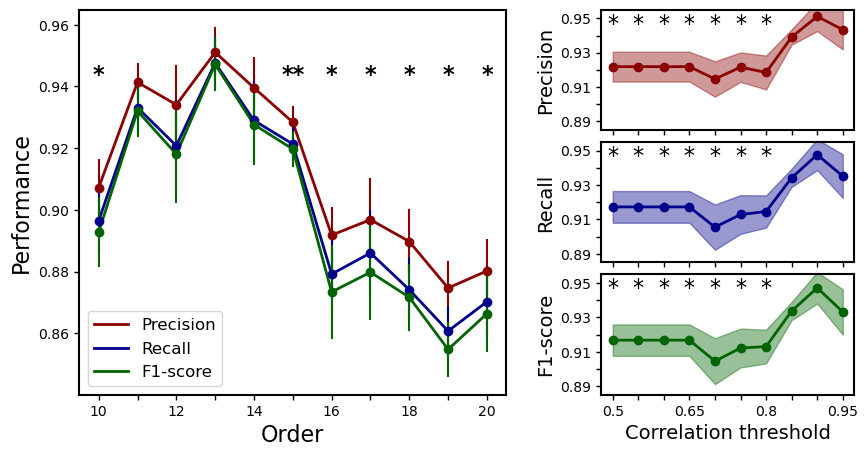

In [64]:
# from matplotlib.gridspec import GridSpec
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

performance_name = ['Precision', 'Recall', 'F1-score']
xtickslabels_orders = [o if (o-10)%2==0 else '' for o in orders]
xtickslabels_th = [round(t, 2) if round((t-0.5)%0.15, 2)==0 else '' for t in thresholds]
yticks_th = np.arange(0.89,0.95+0.01, 0.01)
yticklabels_th = [round(yticks_th[i], 2) if i%2==0 else '' for i in np.arange(len(yticks_th))]
color = ['darkred', 'darkblue', 'darkgreen']

nrows = 1
ncols = 5
fcols = int(round(ncols/2))
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(nrows=nrows, ncols=ncols, wspace=1.2, hspace=0.2)


axs1 = fig.add_subplot(outer[0, 0:int(ncols-fcols)])
for p in np.arange(len(performance_name)):
    df_tmp = df_order[df_order['Metric'] == performance_name[p]]
    performance_matrix = df_tmp[df_tmp['Random'] == 0]['Values'].ravel().reshape(len(orders), M)
    performance_mean = np.mean(performance_matrix, axis=1)
    performance_ste = np.std(performance_matrix, axis=1)/np.sqrt(performance_matrix.shape[0])
    axs1.plot(orders, performance_mean, lw=2, color=color[p], label=performance_name[p])
    axs1.errorbar(orders, performance_mean, yerr=performance_ste, color=color[p], fmt='o')
ds = np.sum(pvalues_orders < 0.05, axis=0)
hpvalue = 0.94
for i in np.arange(len(ds)):
    ds_tmp = ds[i]
    if ds_tmp==len(performance_name):
        axs1.text(orders[i], hpvalue, "*", ha='center', va='bottom', fontsize=16, weight='bold')
    elif ds_tmp==(len(performance_name)-1):
        axs1.text(orders[i], hpvalue, "**", ha='center', va='bottom', fontsize=16, weight='bold')
axs1.set_ylabel('Performance', fontsize=16)
# ax.set_ylim([0.86-0.01, 0.96+0.01])
axs1.set_xticks(orders)
axs1.set_xticklabels(xtickslabels_orders)
axs1.set_xlabel('Order', fontsize=16)
for axis in ['top','bottom','left','right']:
    axs1.spines[axis].set_linewidth(1.5)
axs1.legend(loc='lower left', fontsize=12)
axs1.tick_params(width=1)
axs1.tick_params(labelsize=10)
# axs1.tick_params(axis='x', labelsize=12)


n_rows2 = len(performance_name)
inner2 = gridspec.GridSpecFromSubplotSpec(n_rows2, 1, subplot_spec=outer[0, int(ncols-fcols):ncols], hspace=0.1)
axs2 = []
for p in np.arange(len(performance_name)):
    df_tmp = df_thresholds[df_thresholds['Metric'] == performance_name[p]]
    axs2.append(fig.add_subplot(inner2[p]))
    performance_matrix = df_tmp[df_tmp['Random'] == 0]['Values'].ravel().reshape(thresholds.shape[0], M)
    performance_mean = np.mean(performance_matrix, axis=1)
    performance_ste = np.std(performance_matrix, axis=1)/np.sqrt(performance_matrix.shape[0])
    axs2[p].plot(thresholds, performance_mean, color=color[p], lw=2, marker='o', label='Data')
    axs2[p].fill_between(thresholds, performance_mean-performance_ste,
                         performance_mean+performance_ste, color=color[p], alpha=0.4)
    axs2[p].set_ylabel(performance_name[p], fontsize=14)
    axs2[p].set_yticks(yticks_th)
    axs2[p].set_yticklabels(yticklabels_th)
    axs2[p].set_ylim([yticks_th[0]-0.005, yticks_th[-1]+0.005])
    axs2[p].set_xticks(thresholds)
    if p < len(performance_name)-1:
        axs2[p].set_xticklabels([])
        axs2[p].set_xlabel('')
    else:
        axs2[p].set_xticklabels(xtickslabels_th)
        axs2[p].set_xlabel('Correlation threshold', fontsize=14)
    for axis in ['top','bottom','left','right']:
        axs2[p].spines[axis].set_linewidth(1.5)
    pvalues_tmp = np.array(pvalues_thresholds[p])
    hpvalue = 0.94
    for pvalue,i in zip(pvalues_tmp, range(len(pvalues_tmp))):
        if pvalue < 0.05:
            axs2[p].text(thresholds[i], hpvalue, "*", ha='center', va='bottom', fontsize=16)
    axs2[p].tick_params(width=1)
    axs2[p].tick_params(labelsize=10)
#     axs2[p].tick_params(axis='x', labelsize=12)


# fig.savefig(os.path.join(figures_dir, 'fig_robustness.png'), format='png', dpi=300, facecolor='w')
# fig.savefig(os.path.join(figures_dir, 'fig_robustness.pdf'), format='pdf', dpi=300, facecolor='w')

Plot v2

In [53]:
H_corr = np.corrcoef(np.log10(H_functions**2).T)
H_corr_array = H_corr[np.triu_indices_from(H_corr, k=1)]
density = sp.stats.gaussian_kde(H_corr_array)
xh = np.linspace(-1, 1, 200)
# xh[xh > 0.5]
probability = density(xh)/density(xh).sum()

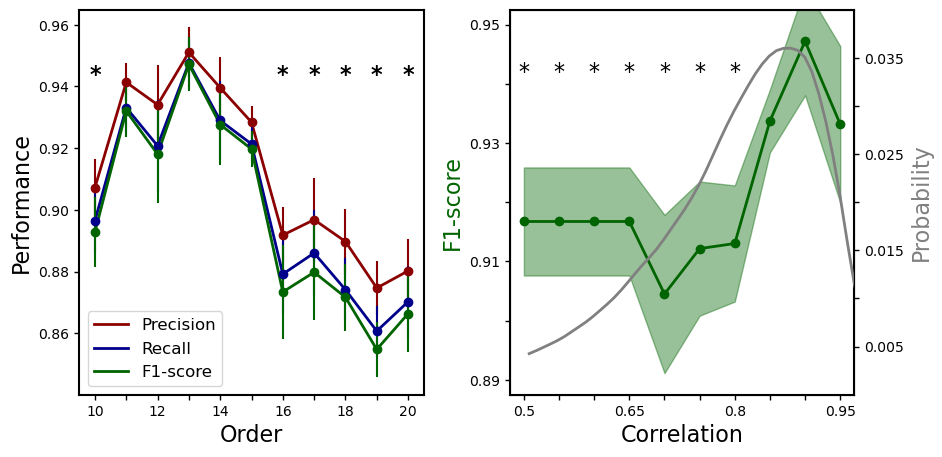

In [80]:
# from matplotlib.gridspec import GridSpec
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

performance_name = ['Precision', 'Recall', 'F1-score']
xtickslabels_orders = [o if (o-10)%2==0 else '' for o in orders]
xtickslabels_th = [round(t, 2) if round((t-0.5)%0.15, 2)==0 else '' for t in thresholds]
yticks_th = np.arange(0.89,0.95+0.01, 0.01)
yticklabels_th = [round(yticks_th[i], 2) if i%2==0 else '' for i in np.arange(len(yticks_th))]
yticks_prob = np.arange(0.005,0.035+0.001, 0.005)
yticklabels_prob = [round(yticks_prob[i], 4) if i%2==0 else '' for i in np.arange(len(yticks_prob))]
color = ['darkred', 'darkblue', 'darkgreen']

nrows = 1
ncols = 6
fcols = int(round(ncols/2))
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(nrows=nrows, ncols=ncols, wspace=1.5, hspace=0.2)


axs1 = fig.add_subplot(outer[0, 0:int(ncols-fcols)])
for p in np.arange(len(performance_name)):
    df_tmp = df_order[df_order['Metric'] == performance_name[p]]
    performance_matrix = df_tmp[df_tmp['Random'] == 0]['Values'].ravel().reshape(len(orders), M)
    performance_mean = np.mean(performance_matrix, axis=1)
    performance_ste = np.std(performance_matrix, axis=1)/np.sqrt(performance_matrix.shape[0])
    axs1.plot(orders, performance_mean, lw=2, color=color[p], label=performance_name[p])
    axs1.errorbar(orders, performance_mean, yerr=performance_ste, color=color[p], fmt='o')
ds = np.sum(pvalues_orders < 0.05, axis=0)
hpvalue = 0.94
for i in np.arange(len(ds)):
    ds_tmp = ds[i]
    if ds_tmp==len(performance_name):
        axs1.text(orders[i], hpvalue, "*", ha='center', va='bottom', fontsize=16, weight='bold')
#     elif ds_tmp==(len(performance_name)-1):
#         axs1.text(orders[i], hpvalue, "**", ha='center', va='bottom', fontsize=16, weight='bold')
axs1.set_ylabel('Performance', fontsize=16)
# ax.set_ylim([0.86-0.01, 0.96+0.01])
axs1.set_xticks(orders)
axs1.set_xticklabels(xtickslabels_orders)
axs1.set_xlabel('Order', fontsize=16)
for axis in ['top','bottom','left','right']:
    axs1.spines[axis].set_linewidth(1.5)
axs1.legend(loc='lower left', fontsize=12)
axs1.tick_params(width=1)
axs1.tick_params(labelsize=10)
# axs1.tick_params(axis='x', labelsize=12)


axs2 = fig.add_subplot(outer[0, int(ncols-fcols):ncols])
p = 2
df_tmp = df_thresholds[df_thresholds['Metric'] == performance_name[p]]
performance_matrix = df_tmp[df_tmp['Random'] == 0]['Values'].ravel().reshape(thresholds.shape[0], M)
performance_mean = np.mean(performance_matrix, axis=1)
performance_ste = np.std(performance_matrix, axis=1)/np.sqrt(performance_matrix.shape[0])
axs2.plot(thresholds, performance_mean, color=color[p], lw=2, marker='o', label='Data')
axs2.fill_between(thresholds, performance_mean-performance_ste,
                  performance_mean+performance_ste, color=color[p], alpha=0.4)
axs2.set_ylabel(performance_name[p], fontsize=16, color=color[p])
axs2.set_yticks(yticks_th)
axs2.set_yticklabels(yticklabels_th)
# axs2.set_yticklabels(yticklabels_th, color=color[p])
axs2.set_ylim([yticks_th[0]-0.0025, yticks_th[-1]+0.0025])
# axs2.set_xlabel('Correlation threshold', fontsize=14)
axs2.set_xlabel('Correlation', fontsize=16)
axs2.set_xticks(thresholds)
axs2.set_xticklabels(xtickslabels_th)
axs2.set_xlim([xtickslabels_th[0]-0.02, xtickslabels_th[-1]+0.02])
axs3 = axs2.twinx()
# axs3.plot(xh[xh > 0.5], density(xh)[xh > 0.5]/density(xh)[xh > 0.5].max(), c='k', lw=2)
axs3.plot(xh[xh > 0.5], probability[xh > 0.5], c='gray', lw=2)
axs3.set_ylabel('Probability', fontsize=16, color='gray')
# yticks_prob = axs3.get_yticks()
# axs3.set_yticks(yticks_prob)
axs3.set_yticks(yticks_prob)
# yticklabels_prob = axs3.get_yticklabels()
axs3.set_yticklabels(yticklabels_prob)
# axs3.set_yticklabels(yticklabels_prob, color='gray')
axs3.set_ylim([yticks_prob[0]-0.005, yticks_prob[-1]+0.005])
for axis in ['top','bottom','left','right']:
    axs2.spines[axis].set_linewidth(1.5)
pvalues_tmp = np.array(pvalues_thresholds[p])
hpvalue = 0.94
for pvalue,i in zip(pvalues_tmp, range(len(pvalues_tmp))):
    if pvalue < 0.05:
        axs2.text(thresholds[i], hpvalue, "*", ha='center', va='bottom', fontsize=16)
axs2.tick_params(width=1)
axs2.tick_params(labelsize=10)
axs3.tick_params(width=1)
axs3.tick_params(labelsize=10)
#     axs2[p].tick_params(axis='x', labelsize=12)

# fig.savefig(os.path.join(figures_dir, 'fig_robustness.png'), format='png', dpi=300, facecolor='w')
# fig.savefig(os.path.join(figures_dir, 'fig_robustness.pdf'), format='pdf', dpi=300, facecolor='w')